### Introdução:

Futebol é um esporte popular no Brasil, que movimenta grandes transações financeiras e altera os ânimos até dos torcedores menos fanáticos.

De acordo com estudo realizado pelo Globo Esporte [1], um treinador permanece apenas cerca de seis meses no comando de uma equipe na elite do futebol brasileiro. As motivações principais para a mudança de técnico seriam a sequência de resultados negativos e as eliminações em demais campeonatos. Percebeu-se que os meses com mais trocas coincidiram com o fim de algumas competições, como Estaduais e Brasileiro. 

Dessa maneira, o principal objetivo deste trabalho é avaliar como o time reage à troca de técnico durante o campeonato brasileiro, e qual a relação desta mudança com o número de derrotas nessa competição.

Para tanto, foi utilizado um dataset do Cartola F.C., disponibilizado por Henrique Gomide em seu github [2]. Foram analisados dados referentes aos anos 2014 a 2017.

[1] https://interativos.globoesporte.globo.com/futebol/especial/rotatividade-dos-tecnicos

[2] https://github.com/henriquepgomide/caRtola/tree/master/data

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

O dataset que reúne informações sobre o Cartola F.C. entre 2014 e 2017 já possui uma limpeza prévia. 

Abrindo o csv:

In [14]:
data = pd.read_csv('dados_agregados_limpos.csv') 

In [15]:
data.head()

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,0.0,19.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,...,2.0,27.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,1.0,4.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,...,1.0,10.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,away.team


In [16]:
data['Posicao'].value_counts()

mei    6516
ata    4050
lat    3045
zag    2628
gol    1328
Name: Posicao, dtype: int64

### Análise exploratória:

1. Quais são as colunas presentes?

In [17]:
data.columns

Index(['A', 'Apelido', 'AtletaID', 'CA', 'CV', 'ClubeID', 'DD', 'DP', 'FC',
       'FD', 'FF', 'FS', 'FT', 'G', 'GC', 'GS', 'I', 'Jogos', 'PE', 'PP',
       'Participou', 'Pontos', 'PontosMedia', 'Posicao', 'Preco',
       'PrecoVariacao', 'RB', 'Rodada', 'SG', 'Status', 'ano', 'avg.A',
       'avg.A.l05', 'avg.CA', 'avg.CV.l05', 'avg.DD', 'avg.DD.l05', 'avg.DP',
       'avg.DP.l05', 'avg.FC', 'avg.FC.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF',
       'avg.FF.l05', 'avg.FS', 'avg.FS.l05', 'avg.FT', 'avg.FT.l05', 'avg.G',
       'avg.G.l05', 'avg.GC', 'avg.GC.l05', 'avg.GS', 'avg.GS.l05', 'avg.I',
       'avg.I.l05', 'avg.PE', 'avg.PE.l05', 'avg.PP', 'avg.PP.l05',
       'avg.Points', 'avg.RB', 'avg.RB.l05', 'avg.SG', 'avg.SG.l05',
       'avg.last05', 'away.score.x', 'dia', 'home.attack', 'home.defend',
       'home.score.x', 'mes', 'pred.away.score', 'pred.home.score',
       'risk_points', 'variable'],
      dtype='object')

De acordo com o arquivo README que acompanha o dataset, os nomes das colunas se referem a:
- Rodada:	número da rodada do Brasileirão	
- ClubeID:	 clube do jogador	ver arquivo times_ids.csv
- AtletaID:	 id do jogador	
- Participou:	indica se o jogador participou daquela rodada	(FALSE:Não, TRUE:Sim)
- Posicao:	 posição do jogador	     (gol:goleiro, zag:zagueiro, lat:lateral, mei:meia, ata:atacante, tec:técnico)
- Jogos:	qtde. de jogos que o jogador participou até aquela rodada	
- Pontos:	pontuação do jogador	
- PontosMedia:	média da pontuação do jogador	
- Preco:	preço do jogador	
- PrecoVariacao:	variação de preço	
- FS:	faltas sofridas	
- PE:	passes errados	
- A:	assistências	
- FT:	finalizações na trave	
- FD:	finalizações defendidas	
- FF:	finalizações para fora	
- G:	gols	
- I:	impedimentos	
- PP:	pênaltis perdidos	
- RB:	roubadas de bola	
- FC:	faltas cometidas	
- GC:	gols contra	
- CA:	cartões amarelo	
- CV:	cartões vermelho	
- SG:	jogos sem sofrer gols	
- DD:	defesas difíceis	
- DP:	defesas de pênalti	
- GS:	gols sofridos	
- ano:	ano dos dados	
- Apelido:	nome/apelido do jogador
- Status:	status do jogador	Provável, Dúvida, Suspenso, Nulo, ...
- avg.Points:	média de pontos do jogador	
- avg.last05:	média de pontos do jogador nas últimas 5 rodadas	
- avg.FS:	média de faltas sofridas	
- avg.FS.l05:	média de faltas sofridas nas últimas 5 rodadas	
- avg.PE:	média de passes errados	
- avg.PE.l05:	média de passes errados nas últimas 5 rodadas	
- avg.A:	média de assistências	
- avg.A.l05:	média de assistências nas últimas 5 rodadas	
- avg.FT:	média de finalizações na trave	
- avg.FT.l05:	média de finalizações na trave nas últimas 5 rodadas	
- avg.FD:	média de finalizações defendidas	
- avg.FD.l05:	média de finalizações defendidas nas últimas 5 rodadas	
- avg.FF:	média de finalizações para fora	
- avg.FF.l05:	média de finalizações para fora nas últimas 5 rodadas	
- avg.G:	média de gols	
- avg.G.l05:	média de gols nas últimas 5 rodadas	
- avg.I:	média de impedimentos	
- avg.I.l05:	média de impedimentos nas últimas 5 rodadas	
- avg.PP:	média de pênaltis perdidos	
- avg.PP.l05:	média de pênaltis perdidos nas últimas 5 rodadas	
- avg.RB:	média de roubadas de bola	
- avg.RB.l05:	média de roubadas de bola nas últimas 5 rodadas	
- avg.FC:	média de faltas cometidas	
- avg.FC.l05:	média de faltas cometidas nas últimas 5 rodadas	
- avg.GC:	média de gols contra	
- avg.GC.l05:	média de gols contra nas últimas 5 rodadas	
- avg.CA:	média de cartões amarelos	
- avg.CV:	média de cartões vermelhos nas últimas 5 rodadas	
- avg.SG:	média de jogos sem sofrer gols	
- avg.SG.l05:	média de jogos sem sofrer gols nas últimas 5 rodadas	
- avg.DD:	média de defesas difíceis	
- avg.DD.l05:	média de defesas difíceis nas últimas 5 rodadas	
- avg.DP:	média de defesas de pênalti	
- avg.DP.l05:	média de defesas de pênalti nas últimas 5 rodadas	
- avg.GS:	média de gols sofridos	
- avg.GS.l05:	média de gols sofridos nas últimas 5 rodadas	
- risk_points:	desvio-padrão da pontuação do jogador	
- mes:	mês que a partida ocorreu	
- dia:	dia que a partida ocorreu	
- away.score.x:	placar to time visitante	
- home.score.x:	placar do time da casa	
- home.attack:	estimativa de força de ataque do time do jogador; estimada a partir de uma regressão de Poisson com base no histórico de confrontos entre os times
- home.defend:	estimativa de força de defesa do time do jogador; estimada a partir de uma regressão de Poisson com base no histórico de confrontos entre os times
- pred.home.score:	estimativa de gols para o time da casa; estimada a partir de 10000 simulações de confronto entre os times usando distribuições de Poisson
- pred.away.score:	estimativa de gols para o time visitante; estimada a partir de 10000 simulações,de confronto entre os times usando distribuições de Poisson
- variable:	indica se o jogador é do time da casa ou visitante (home.team: casa, away.team: visitante)

2. Quais os tipos de objetos presentes?

In [18]:
data.dtypes

A                  float64
Apelido             object
AtletaID             int64
CA                 float64
CV                 float64
ClubeID             object
DD                 float64
DP                 float64
FC                 float64
FD                 float64
FF                 float64
FS                 float64
FT                 float64
G                  float64
GC                 float64
GS                 float64
I                  float64
Jogos              float64
PE                 float64
PP                 float64
Participou            bool
Pontos             float64
PontosMedia        float64
Posicao             object
Preco              float64
PrecoVariacao      float64
RB                 float64
Rodada               int64
SG                 float64
Status              object
                    ...   
avg.FT             float64
avg.FT.l05         float64
avg.G              float64
avg.G.l05          float64
avg.GC             float64
avg.GC.l05         float64
a

3. Determinando quais dados não são de interesse: 

Todas as colunas com os valores relativos às médias (iniciam com 'avg') foram eliminadas, pois não interessam dados que já foram calculados. Não há como saber qual foi o total de jogos considerado para esses cálculos.

As colunas que apresentam estimativas previamente calculadas também foram eliminadas, uma vez que essas estimativas não correspondem ao escopo desse projeto.

Da mesma forma, as colunas que se referem aos pontos e preços de cada jogador no Cartola F.C. não interessaram ao projeto, pois o objetivo principal neste momento não compreendeu o estudo do funcionamento do jogo. As colunas "Participou" e "Status" foram excluídas, pois também se referem exclusivamente à escalação dos times e pontuação no Cartola F.C.

A coluna "Jogos" também foi desprezada, pois a quantidade de rodadas que o jogador participou é relativa às rodadas anteriores, e não interessaram para o estudo. 



In [19]:
data.drop(['avg.A','avg.A.l05', 'avg.CA', 'avg.CV.l05', 'avg.DD', 'avg.DD.l05', 'avg.DP','avg.DP.l05', 'avg.FC', 
           'avg.FC.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF','avg.FF.l05', 'avg.FS', 'avg.FS.l05', 'avg.FT', 'avg.FT.l05', 
           'avg.G','avg.G.l05', 'avg.GC', 'avg.GC.l05', 'avg.GS', 'avg.GS.l05', 'avg.I','avg.I.l05', 'avg.PE', 'avg.PE.l05',
           'avg.PP', 'avg.PP.l05','avg.Points', 'avg.RB', 'avg.RB.l05', 'avg.SG', 'avg.SG.l05','avg.last05', 'home.attack', 
           'home.defend','pred.away.score', 'pred.home.score','risk_points','Jogos','Participou','Status','Pontos',
           'PontosMedia','Preco','PrecoVariacao'], axis=1,inplace=True)
data.head()

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,Posicao,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,0.0,1,1.0,2014,0.0,19.0,1.0,4.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,...,zag,2.0,2,0.0,2014,2.0,27.0,2.0,4.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,1.0,3,0.0,2014,1.0,4.0,2.0,5.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,...,zag,0.0,4,0.0,2014,1.0,10.0,2.0,5.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,zag,0.0,5,1.0,2014,0.0,18.0,0.0,5.0,away.team


In [20]:
# Essas foram as colunas que restaram:
data.columns

Index(['A', 'Apelido', 'AtletaID', 'CA', 'CV', 'ClubeID', 'DD', 'DP', 'FC',
       'FD', 'FF', 'FS', 'FT', 'G', 'GC', 'GS', 'I', 'PE', 'PP', 'Posicao',
       'RB', 'Rodada', 'SG', 'ano', 'away.score.x', 'dia', 'home.score.x',
       'mes', 'variable'],
      dtype='object')

Verificando se existe alguma posição que possui maior tendência a sofrer faltas:

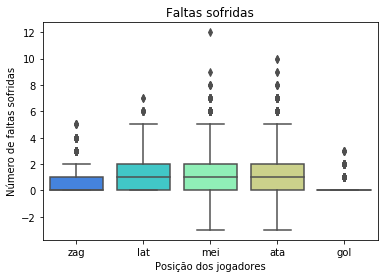

In [23]:
sns.boxplot(x="Posicao", y="FS", data=data,palette='rainbow').set_title('Faltas sofridas')

plt.xlabel("Posição dos jogadores")
plt.ylabel("Número de faltas sofridas")
plt.savefig('boxplot_faltas_sofridas.png')

De acordo com o bloxplot gerado acima, as posições de goleiro e zagueiro sofrem menos faltas que as de lateral, meia e atacante. Entre essas posições, não há uma que se destaque neste quesito.

Então, verificou-se se existe alguma posição que possui maior tendência a cometer faltas:

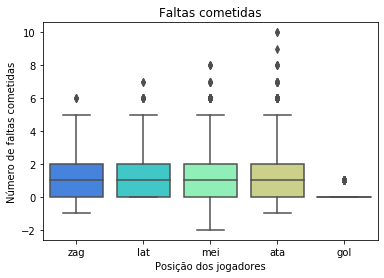

In [24]:
sns.boxplot(x="Posicao", y="FC", data=data,palette='rainbow').set_title('Faltas cometidas')

plt.xlabel("Posição dos jogadores")
plt.ylabel("Número de faltas cometidas")
plt.savefig('boxplot_faltas_cometidas.png')

Novamente, de acordo com o bloxplot gerado acima, a posição de goleiro comete menos faltas que as restantes. Dentre elas,todas tendem a cometer o mesmo número de faltas. 

Com a finalidade de verificar qual posição tem maior tendência a levar cartões amarelos, aplicou-se uma máscara:

In [25]:
mask1 = data["CA"] ==1
ca1=data[mask1]
ca1

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,Posicao,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,0.0,1,1.0,2014,0.0,19.0,1.0,4.0,home.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,1.0,3,0.0,2014,1.0,4.0,2.0,5.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,zag,0.0,5,1.0,2014,0.0,18.0,0.0,5.0,away.team
10,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,3.0,0.0,...,zag,1.0,12,1.0,2014,1.0,26.0,0.0,7.0,away.team
19,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,1.0,0.0,...,zag,0.0,26,0.0,2014,1.0,4.0,2.0,10.0,away.team
23,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,1.0,0.0,...,zag,0.0,3,0.0,2016,2.0,25.0,2.0,5.0,home.team
28,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,1.0,0.0,...,zag,0.0,38,1.0,2016,0.0,11.0,0.0,12.0,away.team
29,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,2.0,1.0,...,zag,2.0,4,1.0,2017,0.0,4.0,0.0,6.0,home.team
30,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,0.0,1.0,...,zag,2.0,5,0.0,2017,0.0,7.0,2.0,6.0,away.team
33,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,1.0,0.0,...,zag,1.0,9,0.0,2017,1.0,22.0,5.0,6.0,home.team


In [26]:
ca1['Posicao'].value_counts()

mei    1183
ata     584
lat     552
zag     546
gol     120
Name: Posicao, dtype: int64

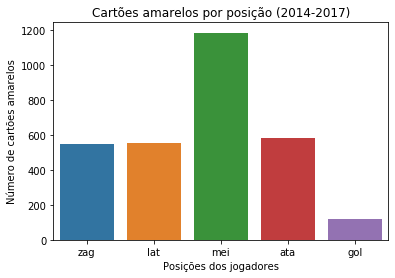

In [27]:
sns.countplot(x='Posicao',data=ca1).set_title('Cartões amarelos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número de cartões amarelos")
plt.savefig('Cartões_amarelos.png')

Porém, deve-se considerar a proporção de jogadores em cada posição, inscritos no campeonato. Para verificar se há mais meias inscritos que atletas em outras posições, determinou-se a quantidade de atletas em cada posição:

In [28]:
data['Posicao'].value_counts()

mei    6516
ata    4050
lat    3045
zag    2628
gol    1328
Name: Posicao, dtype: int64

De fato, há mais meias e menos goleiros, comparado ao restante das posições. Tentou-se resolver este problema calculando a média de cartões por posição.

Assim, o dataframe foi agrupado por posição do jogador:

In [29]:
posicao=data.groupby(["Posicao"]).mean()

In [30]:
posicao.index

Index(['ata', 'gol', 'lat', 'mei', 'zag'], dtype='object', name='Posicao')

In [31]:
posicao

,A,AtletaID,CA,CV,DD,DP,FC,FD,FF,FS,...,PE,PP,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes
Posicao,,,,,,,,,,,,,,,,,,,,,
ata,0.087160,70623.110370,0.143951,0.005679,0.00000,0.000000,1.261481,0.425679,0.554321,1.417531,...,2.064938,0.007407,0.577778,19.535062,0.000000,2016.092840,1.006420,15.695802,1.404198,8.166667
gol,0.003012,57625.685994,0.090361,0.003765,1.53012,0.033133,0.021837,0.000000,0.000000,0.201807,...,0.661898,0.000000,0.007530,19.004518,0.306476,2015.908133,1.012048,15.905873,1.454066,8.048193
lat,0.089655,67741.463711,0.181281,0.009524,0.00000,0.000000,1.263383,0.155008,0.235468,1.134975,...,3.178325,0.003284,1.367159,20.264368,0.303777,2016.001642,0.962890,15.754680,1.403284,8.295238
mei,0.069061,69973.149939,0.181093,0.009362,0.00000,0.000000,1.344997,0.262891,0.385820,1.258594,...,2.567680,0.002762,1.321823,20.182167,0.001842,2016.079190,0.969920,15.728361,1.401013,8.282228
zag,0.019026,67516.598554,0.207763,0.009513,0.00000,0.000000,0.999239,0.125571,0.238204,0.710426,...,1.914003,0.000381,1.102740,20.210426,0.317732,2016.098554,0.977930,15.735540,1.414384,8.290335


Notou-se que a coluna 'Posicao' se tornou index após a aplicação do método groupby. Não é possível plotar o gráfico utilizando o index como eixo x. Dessa forma, foi necessária a criação de uma coluna equivalente:

In [32]:
posicao['Posicao'] = posicao.index

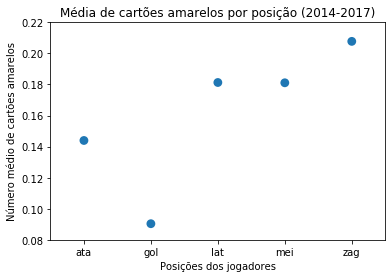

In [33]:
sns.pointplot(x="Posicao", y="CA", data=posicao,join=False).set(ylim=(0.08, 0.22),
                                                                title='Média de cartões amarelos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de cartões amarelos")

plt.savefig('Média de cartões amarelos por posição.png')

Ao gerar os números médios de cartões amarelos referentes à cada posição, notou-se que, ao contrário do que foi visto na análise anterior, os zagueiros apresentam maior número de cartões médios neste intervalo de tempo. Essa discrepância evidencia a importância de trabalhar com dados balanceados de acordo com a amostragem.

Esse dataset "posicao" gerado traz muitas informações interessantes relativas às performances médias de cada posição de jogador em campo. Dentre elas, destacou-se:

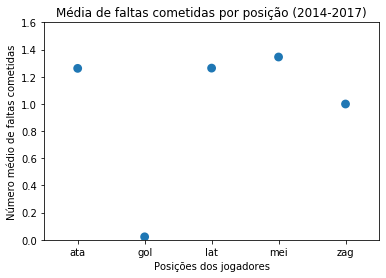

In [34]:
sns.pointplot(x="Posicao", y="FC", data=posicao,join=False).set(ylim=(0.00, 1.6),
title='Média de faltas cometidas por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de faltas cometidas")
plt.savefig('Média de faltas cometidas por posição.png')

Através do gráfico acima, pode-se inferir que a posição que mais comete faltas é de meia. Dentre os atletas de linha, os que menos cometem faltas são os zagueiros.

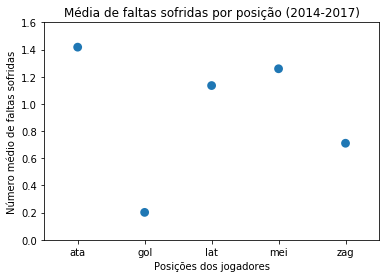

In [35]:
sns.pointplot(x="Posicao", y="FS", data=posicao,join=False).set(ylim=(0.00, 1.6),
title='Média de faltas sofridas por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de faltas sofridas")

plt.savefig('Média de faltas sofridas por posição.png')

No que se referem às faltas sofridas, dentre os atletas de linha, a posição que mais sofre é a de atacante, seguidas pelas de meia, lateral e zagueiro.

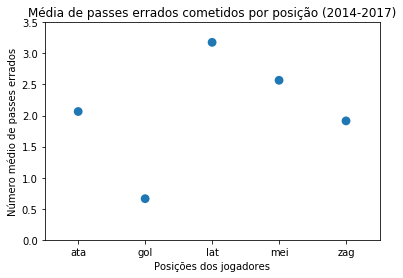

In [36]:
sns.pointplot(x="Posicao", y="PE", data=posicao,join=False, ci=68).set(ylim=(0.00, 3.5),
title='Média de passes errados cometidos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de passes errados")
plt.savefig('Média de passes errados por posição.png')

Já sobre a posição que mais erra passes durante o jogo, pode-se perceber que é a de lateral. Possivelmente, porque é a posição que faz o maior número de cruzamentos e inversão de jogo. 

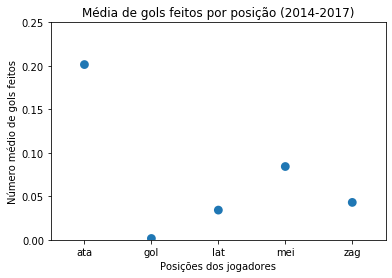

In [37]:
sns.pointplot(x="Posicao", y="G", data=posicao,join=False, ci=68).set(ylim=(0.00, 0.25),
title='Média de gols feitos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de gols feitos")

plt.savefig('Média de gols feitos por posição.png')

É importante ressaltar também que mesmo tratando os dados com base no número total de jogadores em cada posição (utilizando a média), algumas análises permanecem tendenciosas. É necessário ter cautela ao fazer uma análise em que o número de gols é um parâmetro para decidir o quão qualificado é o jogador, por exemplo. Isso porque atacantes têm uma maior média de gols feitos (como observado no gráfico acima), já que é se trata da atribuição principal de sua função. Do mesmo modo, apenas goleiros terão dados referentes à defesas difíceis, defesas difíceis e gols sofridos, como evidenciado abaixo:

In [38]:
posicao['DD'] #DD: defesas difíceis; apenas goleiros apresentam esse parâmetro

Posicao
ata    0.00000
gol    1.53012
lat    0.00000
mei    0.00000
zag    0.00000
Name: DD, dtype: float64

In [39]:
posicao['DP'] #DP: defesas de pênalti; apenas goleiros apresentam esse parâmetro

Posicao
ata    0.000000
gol    0.033133
lat    0.000000
mei    0.000000
zag    0.000000
Name: DP, dtype: float64

In [40]:
posicao['GS'] #GS: gols sofridos; apenas goleiros apresentam esse parâmetro

Posicao
ata    0.000000
gol    1.192771
lat    0.000000
mei    0.000000
zag    0.000000
Name: GS, dtype: float64

A fim de continuar a análise exploratória, determinou-se a correlação entre os pares do dataframe:

In [41]:
corr=data.corr()

In [42]:
corr

,A,AtletaID,CA,CV,DD,DP,FC,FD,FF,FS,...,PE,PP,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes
A,1.000000,-0.012888,-0.001012,0.016308,-0.047791,-0.012015,0.041546,0.054915,0.050675,0.070613,...,0.084166,0.011819,0.030105,-0.003188,-0.026436,-0.013189,0.109758,-0.003166,0.120208,-0.000935
AtletaID,-0.012888,1.000000,-0.014142,-0.015765,-0.117572,-0.020552,0.029202,0.009843,0.016835,0.001042,...,-0.024859,-0.026175,0.049881,0.058792,-0.062498,0.251485,0.021521,-0.022084,-0.014722,0.055921
CA,-0.001012,-0.014142,1.000000,-0.022198,-0.038862,-0.007307,0.275372,0.003000,0.001535,0.059475,...,0.034901,-0.000031,0.050542,0.014779,-0.007699,0.010084,0.024945,-0.006925,-0.014080,0.014749
CV,0.016308,-0.015765,-0.022198,1.000000,-0.016556,-0.004409,0.066949,-0.016944,-0.003585,-0.004825,...,-0.004052,-0.005136,0.005607,0.003565,-0.020493,-0.004379,0.018949,-0.000211,0.004825,0.004495
DD,-0.047791,-0.117572,-0.038862,-0.016556,1.000000,0.144955,-0.189610,-0.093792,-0.112865,-0.143466,...,-0.171013,-0.011951,-0.168587,-0.010856,0.103441,-0.016409,0.004773,0.017444,0.007653,-0.014810
DP,-0.012015,-0.020552,-0.007307,-0.004409,0.144955,1.000000,-0.044209,-0.021955,-0.026420,-0.036651,...,-0.033757,-0.002798,-0.037970,0.006131,0.022105,0.004983,0.008843,0.002722,-0.001938,0.006252
FC,0.041546,0.029202,0.275372,0.066949,-0.189610,-0.044209,1.000000,0.074995,0.085627,0.182240,...,0.164722,0.000437,0.184918,0.002109,-0.074984,-0.022044,-0.001792,0.005988,-0.020822,0.002122
FD,0.054915,0.009843,0.003000,-0.016944,-0.093792,-0.021955,0.074995,1.000000,0.155272,0.125394,...,0.119581,0.051672,0.000478,0.010309,-0.098692,-0.011931,0.005200,0.014610,-0.007337,0.009012
FF,0.050675,0.016835,0.001535,-0.003585,-0.112865,-0.026420,0.085627,0.155272,1.000000,0.132628,...,0.119553,0.039806,0.030387,0.015028,-0.094319,-0.006515,-0.004768,0.010044,-0.017699,0.012952
FS,0.070613,0.001042,0.059475,-0.004825,-0.143466,-0.036651,0.182240,0.125394,0.132628,1.000000,...,0.217921,0.029966,0.145240,0.007253,-0.100998,-0.022040,-0.002777,0.010940,-0.011994,0.005349


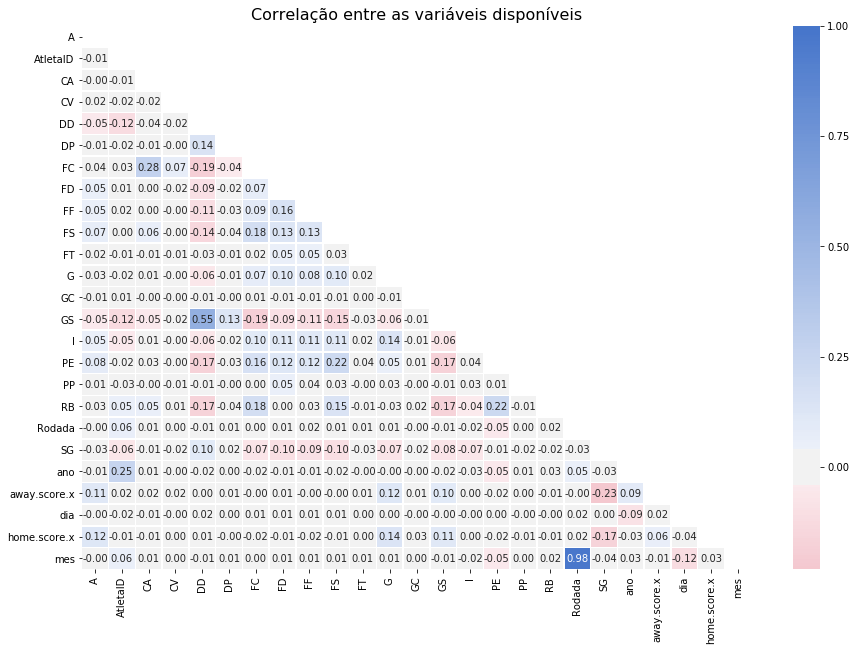

In [43]:
def correlation_matrix(corr, title=""):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    plt.subplots(figsize=(15, 10))
    cmap = sns.diverging_palette(6, 255, as_cmap=True)
    
    chart = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, annot=True, fmt='.2f')
    plt.title(title, fontsize=16)
    
    return chart

corr_plot = correlation_matrix(corr, title='Correlação entre as variáveis disponíveis')
plt.savefig('correlacao.png')

A partir da matriz de correlação gerada, pode-se inferir alguns aspectos:

- O maior valor absoluto de correlação é dado entre o par 'Rodada' e 'mês'. Isso ocorre porque a tabela do campeonato segue a mesma sequência todos os anos, ou seja, uma determinada rodada tende a ocorrer no mesmo mês nos anos seguintes.

Analisando apenas as correlações com valor correspondente acima de 0.15 em módulo (que se trata de um filtro determinado com base nos outros valores da matriz) entre variáveis numéricas, algumas observações podem ser realizadas. Dentre elas, destacou-se:

- O número de faltas cometidas se correlaciona positivamente com o número de cartões amarelos que o atleta recebeu. Isso pode estar associado ao fato que o cartão é das possíveis penalidades que o jogador pode receber ao cometer uma falta. Do mesmo modo, se correlaciona positivamente às faltas sofridas (se uma falta é cometida por um lado, o outro lado sofre a falta), aos passes errados e às roubadas de bola. Também se correlaciona negativamente às defesas difíceis e ao número de gols sofridos. 

- As defesas difíceis estão correlacionadas positivamente aos gols sofridos, possivelmente porque a mesma posição (goleiro) que faz uma defesa difícil também é aquela que sofre o gol.

- Roubadas de bola se correlacionam positivamente aos passes errados, possivelmente porque o time que erra os passes perde a posse da bola para o adversário. Os passes errados se correlacionam positivamente às faltas sofridas.



### Análise dos técnicos

Feita a análise exploratória inicial, já foi possível se familizar com os dados. Sendo assim, tentou-se limpar o dataset mantendo os dados para técnicos:

In [44]:
df = pd.read_csv('2017_dados_agregados.csv') #abrindo os dados raw para limpá-los de outra forma, mantendo os dados 
                                               #de técnicos

In [45]:
print(df.shape)
df.head(10)

(43821, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
0,36443,1,285.0,True,gol,1.0,5.0,5.00,10.60,1.60,...,1.000000,4.0,19.0,1.0,0.0,NaN,NaN,NaN,NaN,home.team
1,36443,2,285.0,True,gol,2.0,-3.0,1.00,8.27,-2.33,...,1.000000,4.0,27.0,2.0,2.0,NaN,NaN,NaN,NaN,away.team
2,36443,3,285.0,True,gol,3.0,-2.6,-0.20,6.81,-1.46,...,1.000000,5.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,home.team
3,36443,4,285.0,True,gol,4.0,4.0,0.85,7.96,1.15,...,1.000000,5.0,10.0,2.0,1.0,NaN,NaN,NaN,NaN,home.team
4,36443,5,285.0,True,gol,5.0,5.0,1.68,8.61,0.65,...,1.000000,5.0,18.0,0.0,0.0,NaN,NaN,NaN,NaN,away.team
5,36443,6,285.0,True,gol,6.0,1.2,1.60,8.02,-0.59,...,1.000000,5.0,21.0,1.0,1.0,NaN,NaN,NaN,NaN,away.team
6,36443,7,285.0,True,gol,7.0,-3.3,0.90,6.75,-1.27,...,1.000000,5.0,25.0,1.0,3.0,NaN,NaN,NaN,NaN,home.team
7,36443,8,285.0,True,gol,8.0,3.0,1.16,7.55,0.80,...,1.000000,5.0,28.0,2.0,0.0,NaN,NaN,NaN,NaN,home.team
8,36443,9,285.0,True,gol,9.0,-1.5,0.86,6.71,-0.84,...,3.320910,6.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,away.team
9,36443,10,285.0,True,gol,10.0,-4.0,0.37,6.01,-0.70,...,3.649901,7.0,17.0,2.0,1.0,NaN,NaN,NaN,NaN,away.team


In [46]:
df['Posicao'].value_counts() #checando: esse dataframe contém as informações de técnicos

mei    12107
ata     7759
lat     5428
zag     5008
gol     2743
tec     2293
Name: Posicao, dtype: int64

Foi utilizado o mesmo código para limpeza de dataset, modificando apenas a linha em que o provedor remove os dados dos técnicos.

In [47]:
#utilizando o código da limpeza original, feita pelo provedor do dataset
cols_scouts_def = ['CA','CV','DD','DP','FC','GC','GS','RB','SG'] # alphabetical order
cols_scouts_atk = ['A','FD','FF','FS','FT','G','I','PE','PP'] # alphabetical order
cols_scouts = cols_scouts_def + cols_scouts_atk

scouts_weights = np.array([-2.0, -5.0, 3.0, 7.0, -0.5, -6.0, -2.0, 1.7, 5.0, 5.0, 1.0, 0.7, 0.5, 3.5, 8.0, -0.5, -0.3, -3.5])

ROUND_TO_PREDICT = 38

In [48]:
print("Dimensões originais dos dados: ", df.shape)

# remove todas as linhas cujo scouts são NANs 
df_clean = df.dropna(how='all', subset=cols_scouts)
print('qtde. de jogadores com scouts: ', df_clean.shape[0])

# remove todas as linhas com rodada == 0
df_clean = df_clean[df_clean['Rodada'] > 0]
print("qtde. de linhas após eliminação da rodada 0: ", df_clean.shape[0])

# remove todos os jogadores que não participaram de alguma rodada
df_clean = df_clean[(df_clean['Participou'] == True) | (df_clean['PrecoVariacao'] != 0)]
print("qtde. de linhas com jogadores que participaram de alguma rodada: ", df_clean.shape[0])

# altera os Status = NAN para 'Provável'
df_clean.loc[df_clean.Status.isnull(), 'Status'] = 'Provável'

# atualiza nomes dos jogadores sem ids e remove jogadores sem nome
df_ids =  df.groupby('AtletaID')['Apelido'].unique()
dict_ids = dict(zip(df_ids.index, [str(v[-1]) for v in df_ids.values]))
dict_ids = {k:v for k,v in dict_ids.items() if v != 'nan'}
df_clean['Apelido'] = df_clean['AtletaID'].map(dict_ids)
df_clean = df_clean[~df_clean['Apelido'].isnull()]
print("qtde. de jogadores com nome: ", df_clean.shape[0])

# remove jogadores sem posição 
# modificação!! > não foi removido a posição 'técnico'
df_clean = df_clean[(~df_clean['Posicao'].isnull())]

print("qtde. de linhas com posições válidas: ", df_clean.shape[0])

# preenche NANs restantes com zeros (verificado antes!)
df_clean.fillna(value=0, inplace=True)

print("Dimensão dos dados após as limpezas: ", df_clean.shape)
df_clean.head(10)

Dimensões originais dos dados:  (43821, 77)
qtde. de jogadores com scouts:  43821
qtde. de linhas após eliminação da rodada 0:  43821
qtde. de linhas com jogadores que participaram de alguma rodada:  43821
qtde. de jogadores com nome:  29118
qtde. de linhas com posições válidas:  24545
Dimensão dos dados após as limpezas:  (24545, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
53,36540,1,285.0,True,zag,1.0,2.0,2.00,12.88,-2.12,...,1.000000,4.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,home.team
54,36540,2,285.0,True,zag,2.0,3.4,2.70,12.04,-0.84,...,1.000000,4.0,27.0,2.0,2.0,0.0,0.0,0.0,0.0,away.team
55,36540,3,285.0,True,zag,3.0,0.1,1.83,10.85,-1.19,...,1.000000,5.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
56,36540,4,285.0,True,zag,4.0,0.9,1.60,10.61,-0.24,...,1.000000,5.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
57,36540,5,285.0,True,zag,5.0,1.2,1.52,10.45,-0.16,...,1.000000,5.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,away.team
58,36540,7,285.0,True,zag,6.0,1.9,1.58,10.14,-0.31,...,1.000000,5.0,25.0,1.0,3.0,0.0,0.0,0.0,0.0,home.team
59,36540,8,285.0,True,zag,7.0,10.7,2.88,11.87,1.73,...,1.000000,5.0,28.0,2.0,0.0,0.0,0.0,0.0,0.0,home.team
60,36540,9,285.0,True,zag,8.0,4.1,3.03,11.20,-0.67,...,3.226298,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,away.team
61,36540,10,285.0,True,zag,9.0,0.4,2.74,10.70,-0.50,...,3.195153,7.0,17.0,2.0,1.0,0.0,0.0,0.0,0.0,away.team
62,36540,11,285.0,True,zag,10.0,10.0,3.47,12.69,1.99,...,3.971580,7.0,20.0,4.0,0.0,0.0,0.0,0.0,0.0,home.team


In [49]:
df_clean['Posicao'].value_counts() #verificação: a posição foi mantida após a limpeza

mei    8394
ata    5140
lat    3899
zag    3299
gol    2107
tec    1706
Name: Posicao, dtype: int64

Continuando a limpeza, de acordo com o que foi feito pelo provedor do dataset:

In [50]:
#Atualização dos times para os jogadores
df_teams = pd.read_csv('times_ids.csv')
df_teams = df_teams.dropna()
print(df_teams.shape)
df_teams.head()

(23, 11)


,nome.cbf,nome.cartola,nome.completo,cod.older,cod.2017,cod.2018,id,abreviacao,escudos.60x60,escudos.45x45,escudos.30x30
0,América - MG,América-MG,America MG,327,327,327,327,AME,https://s.glbimg.com/es/sde/f/organizacoes/201...,https://s.glbimg.com/es/sde/f/organizacoes/201...,https://s.glbimg.com/es/sde/f/organizacoes/201...
3,Atlético - MG,Atlético-MG,Atletico Mineiro,282,282,282,282,ATL,https://s.glbimg.com/es/sde/f/equipes/2017/11/...,https://s.glbimg.com/es/sde/f/equipes/2017/11/...,https://s.glbimg.com/es/sde/f/equipes/2017/11/...
4,Atlético - PR,Atlético-PR,Atletico Paranaense,293,293,293,293,ATL,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...
5,Atletico - PR,Atlético-PR,Atletico Paranaense,293,293,293,293,ATL,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...
8,Bahia - BA,Bahia,EC Bahia,207,265,265,265,BAH,https://s.glbimg.com/es/sde/f/equipes/2014/04/...,https://s.glbimg.com/es/sde/f/equipes/2013/12/...,https://s.glbimg.com/es/sde/f/equipes/2013/12/...


In [51]:
# não rodar essa célula duas vezes!
#atualizando nomes na tabela principal
dict_teams_id = dict(zip(df_teams['id'], df_teams['nome.cartola']))
dict_teams_id.update(dict(zip(df_teams['cod.older'], df_teams['nome.cartola'])))

df_clean['ClubeID'] = df_clean['ClubeID'].astype(np.int).map(dict_teams_id)
df_clean = df_clean.dropna()

print(df_clean.shape)
df_clean.head()

(20525, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
53,36540,1,Internacional,True,zag,1.0,2.0,2.00,12.88,-2.12,...,1.0,4.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,home.team
54,36540,2,Internacional,True,zag,2.0,3.4,2.70,12.04,-0.84,...,1.0,4.0,27.0,2.0,2.0,0.0,0.0,0.0,0.0,away.team
55,36540,3,Internacional,True,zag,3.0,0.1,1.83,10.85,-1.19,...,1.0,5.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
56,36540,4,Internacional,True,zag,4.0,0.9,1.60,10.61,-0.24,...,1.0,5.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
57,36540,5,Internacional,True,zag,5.0,1.2,1.52,10.45,-0.16,...,1.0,5.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,away.team


In [52]:
df_clean['Posicao'].value_counts() #verificação

mei    7087
ata    4255
lat    3220
zag    2841
gol    1723
tec    1399
Name: Posicao, dtype: int64

Não foi efetuada a atualização dos dados cumulativos de scout para 2015, pois esses dados de scout (passes errados, faltas cometidas, etc) não serão utilizados para a tabela dos técnicos. 

Por fim, foram apagadas as linhas repetidas do dataframe. Isso acontece pois, a partir da primeira participação de um jogador no campeonato, ele aparece em todas as rodadas subsequentes, mesmo que não tenha jogado.

In [53]:
df_clean.drop_duplicates(subset=['AtletaID', 'ano']+cols_scouts, keep='first', inplace=True)

In [54]:
df_clean['Posicao'].value_counts() #verificação

mei    6903
ata    4108
lat    3183
zag    2782
gol    1403
tec      65
Name: Posicao, dtype: int64

In [55]:
print("Dimensões dos dados após toda a limpeza de dados: ", df_clean.shape)
df_clean.to_csv('dados_limpos_com_tec.csv', index=False)

Dimensões dos dados após toda a limpeza de dados:  (18444, 77)


O csv gerado foi aberto:

In [56]:
tecnicos = pd.read_csv('dados_limpos_com_tec.csv')

In [57]:
tecnicos.head()

,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
0,36540,1,Internacional,True,zag,1.0,2.0,2.00,12.88,-2.12,...,1.0,4.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,home.team
1,36540,2,Internacional,True,zag,2.0,3.4,2.70,12.04,-0.84,...,1.0,4.0,27.0,2.0,2.0,0.0,0.0,0.0,0.0,away.team
2,36540,3,Internacional,True,zag,3.0,0.1,1.83,10.85,-1.19,...,1.0,5.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
3,36540,4,Internacional,True,zag,4.0,0.9,1.60,10.61,-0.24,...,1.0,5.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
4,36540,5,Internacional,True,zag,5.0,1.2,1.52,10.45,-0.16,...,1.0,5.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,away.team


Quais são as colunas do dataset?

In [58]:
tecnicos.columns

Index(['AtletaID', 'Rodada', 'ClubeID', 'Participou', 'Posicao', 'Jogos',
       'Pontos', 'PontosMedia', 'Preco', 'PrecoVariacao', 'FS', 'PE', 'A',
       'FT', 'FD', 'FF', 'G', 'I', 'PP', 'RB', 'FC', 'GC', 'CA', 'CV', 'SG',
       'DD', 'DP', 'GS', 'ano', 'Apelido', 'Status', 'avg.Points',
       'avg.last05', 'avg.FS', 'avg.FS.l05', 'avg.PE', 'avg.PE.l05', 'avg.A',
       'avg.A.l05', 'avg.FT', 'avg.FT.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF',
       'avg.FF.l05', 'avg.G', 'avg.G.l05', 'avg.I', 'avg.I.l05', 'avg.PP',
       'avg.PP.l05', 'avg.RB', 'avg.RB.l05', 'avg.FC', 'avg.FC.l05', 'avg.GC',
       'avg.GC.l05', 'avg.CA', 'avg.CV.l05', 'avg.SG', 'avg.SG.l05', 'avg.DD',
       'avg.DD.l05', 'avg.DP', 'avg.DP.l05', 'avg.GS', 'avg.GS.l05',
       'risk_points', 'mes', 'dia', 'home.score.x', 'away.score.x',
       'pred.home.score', 'pred.away.score', 'home.attack', 'home.defend',
       'variable'],
      dtype='object')

Determinando os dados que não são de interesse, do mesmo modo que para o primeiro dataset:

Todas as colunas com os valores relativos às médias (iniciam com 'avg') foram eliminadas, pois não interessam dados que já foram calculados. Não há como saber qual foi o total de jogos considerado para esses cálculos.

As colunas que apresentam estimativas previamente calculadas também foram eliminadas, uma vez que essas estimativas não correspondem ao escopo desse projeto.

Da mesma forma, as colunas que se referem aos pontos e preços de cada jogador no Cartola F.C. não interessaram ao projeto, pois o objetivo principal neste momento não compreendeu o estudo do funcionamento do jogo. As colunas "Participou" e "Status" foram excluídas, pois também se referem exclusivamente à escalação dos times e pontuação no Cartola F.C.

Dessa vez, eliminou-se todas as colunas referentes aos scouts. Esses dados não foram considerados durante a limpeza, e não possuem valores correspondentes aos técnicos.

A coluna "Jogos", no entanto, não foi desprezada, pois pode ser interessante para verificar quantas rodadas o técnico permaneceu no comando de uma equipe. 



In [59]:
tecnicos.drop(['avg.A','avg.A.l05', 'avg.CA', 'avg.CV.l05', 'avg.DD', 'avg.DD.l05', 'avg.DP','avg.DP.l05', 'avg.FC', 
           'avg.FC.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF','avg.FF.l05', 'avg.FS', 'avg.FS.l05', 'avg.FT', 'avg.FT.l05', 
           'avg.G','avg.G.l05', 'avg.GC', 'avg.GC.l05', 'avg.GS', 'avg.GS.l05', 'avg.I','avg.I.l05', 'avg.PE', 'avg.PE.l05',
           'avg.PP', 'avg.PP.l05','avg.Points', 'avg.RB', 'avg.RB.l05', 'avg.SG', 'avg.SG.l05','avg.last05', 'home.attack', 
           'home.defend','pred.away.score', 'pred.home.score','risk_points','Participou','Status','Pontos',
           'PontosMedia','Preco','PrecoVariacao','FS', 'PE', 'A','FT', 'FD', 'FF', 'G', 'I', 'PP', 'RB', 'FC', 'GC', 'CA', 
           'CV', 'SG','DD', 'DP', 'GS'], axis=1,inplace=True)

In [60]:
tecnicos.head()

,AtletaID,Rodada,ClubeID,Posicao,Jogos,ano,Apelido,mes,dia,home.score.x,away.score.x,variable
0,36540,1,Internacional,zag,1.0,2014,Juan,4.0,19.0,1.0,0.0,home.team
1,36540,2,Internacional,zag,2.0,2014,Juan,4.0,27.0,2.0,2.0,away.team
2,36540,3,Internacional,zag,3.0,2014,Juan,5.0,4.0,2.0,1.0,home.team
3,36540,4,Internacional,zag,4.0,2014,Juan,5.0,10.0,2.0,1.0,home.team
4,36540,5,Internacional,zag,5.0,2014,Juan,5.0,18.0,0.0,0.0,away.team


Eliminou-se todos os dados referentes às posições de jogadores que não são técnicos. Para tanto, utilizou-se uma máscara:

In [61]:
mask2 = tecnicos["Posicao"] =="tec"
tec=tecnicos[mask2]
tec.head()

,AtletaID,Rodada,ClubeID,Posicao,Jogos,ano,Apelido,mes,dia,home.score.x,away.score.x,variable
144,36940,1,Santos,tec,1.0,2014,Oswaldo de Oliveira,4.0,20.0,1.0,1.0,home.team
145,36940,1,Palmeiras,tec,1.0,2015,Oswaldo de Oliveira,5.0,9.0,2.0,2.0,home.team
146,36940,1,Sport,tec,23.0,2016,Oswaldo de Oliveira,5.0,14.0,1.0,0.0,away.team
147,36940,26,Atlético-MG,tec,1.0,2017,Oswaldo de Oliveira,10.0,1.0,0.0,2.0,away.team
148,36943,1,Atlético-MG,tec,1.0,2014,Paulo Autuori,4.0,20.0,0.0,0.0,home.team


In [62]:
tec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 144 to 18398
Data columns (total 12 columns):
AtletaID        65 non-null int64
Rodada          65 non-null int64
ClubeID         65 non-null object
Posicao         65 non-null object
Jogos           65 non-null float64
ano             65 non-null int64
Apelido         65 non-null object
mes             65 non-null float64
dia             65 non-null float64
home.score.x    65 non-null float64
away.score.x    65 non-null float64
variable        65 non-null object
dtypes: float64(5), int64(3), object(4)
memory usage: 6.6+ KB


O dataset obtido (tec) possui 65 linhas.

In [63]:
#duplicando a coluna 'Rodada' para utilizá-la como index:
tec["Rodada2"]=tec["Rodada"]

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
#set_index para as colunas 'ano' e 'rodada' para facilitar a visualização
tec.set_index(keys = ["ano", "Rodada"], inplace = True) 

In [65]:
tec.sort_index(inplace = True)

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [66]:
tec

AtletaID        ClubeID Posicao  Jogos               Apelido  \
ano  Rodada                                                                 
2014 1          36940         Santos     tec    1.0   Oswaldo de Oliveira   
     1          36943    Atlético-MG     tec    1.0         Paulo Autuori   
     1          37246        Vitória     tec    1.0            Ney Franco   
     1          37281    Corinthians     tec    1.0          Mano Menezes   
     1          37306      Palmeiras     tec    1.0         Gilson Kleina   
     1          39850       Botafogo     tec    1.0        Vagner Mancini   
     1          40006  Internacional     tec    1.0            Abel Braga   
     1          62136       Cruzeiro     tec    1.0      Marcelo Oliveira   
     1          87211          Sport     tec    1.0      Eduardo Baptista   
     2          40025    Atlético-MG     tec    1.0           Levir Culpi   
     4          84863      Palmeiras     tec    1.0      Alberto Valentim   
     10         79343    Atlético-PR     tec    1.0                Doriva   
     12         41327       Flamengo     tec    1.0  Vanderlei Luxemburgo   
     19         40990      Palmeiras     tec    1.0        Dorival Júnior   
     19         84761    Atlético-PR     tec    1.0    Claudinei Oliveira   
2015 1          36940      Palmeiras     tec    1.0   Oswaldo de Oliveira   
     1          40025    Atlético-MG     tec    1.0           Levir Culpi   
     1          41327       Flamengo     tec    1.0  Vanderlei Luxemburgo   
     1          60780    Chapecoense     tec    1.0     Vinícius Eutrópio   
     1          62136       Cruzeiro     tec    1.0      Marcelo Oliveira   
     1          79343          Vasco     tec    1.0                Doriva   
     1          87211          Sport     tec    1.0      Eduardo Baptista   
     7          84863      Palmeiras     tec    1.0      Alberto Valentim   
     13         40990         Santos     tec    1.0        Dorival Júnior   
     23         37281       Cruzeiro     tec    1.0          Mano Menezes   
     28         37245    Chapecoense     tec   18.0         Guto Ferreira   
2016 1          36940          Sport     tec   23.0   Oswaldo de Oliveira   
     1          36943    Atlético-PR     tec    1.0         Paulo Autuori   
     1          37245    Chapecoense     tec   28.0         Guto Ferreira   
     1          39850        Vitória     tec   37.0        Vagner Mancini   
...               ...            ...     ...    ...                   ...   
2017 1          37245    Chapecoense     tec    1.0         Guto Ferreira   
     1          37281       Cruzeiro     tec    1.0          Mano Menezes   
     1          39850    Chapecoense     tec    1.0        Vagner Mancini   
     1          40006     Fluminense     tec    1.0            Abel Braga   
     1          40990         Santos     tec    1.0        Dorival Júnior   
     1          41929         Grêmio     tec    1.0         Renato Gaúcho   
     1          42411      Palmeiras     tec    1.0                  Cuca   
     1          70696    Corinthians     tec    1.0         Fábio Carille   
     1          79437    Atlético-MG     tec    1.0        Roger Machado    
     1          86486          Vasco     tec    1.0         Milton Mendes   
     1          92180       Botafogo     tec    1.0          Jair Ventura   
     1          95780       Flamengo     tec    1.0            Zé Ricardo   
     1          97341      São Paulo     tec    1.0          Rogério Ceni   
     3          87211    Atlético-PR     tec    1.0      Eduardo Baptista   
     4          41327          Sport     tec    1.0  Vanderlei Luxemburgo   
     4          70323          Bahia     tec    1.0              Jorginho   
     5          41363        Vitória     tec    1.0       Alexandre Gallo   
     7          40025         Santos     tec    1.0           Levir Culpi   
     12         60780    Chapecoense     tec    1.0     Vinícius Eutrópio   
     15  

Como pode ser observado na Tabela acima, os dados de técnico não estão presentes para todas as rodadas. Uma nova linha correspondente ao técnico é gerada quando há uma nova contratação no clube, ou quando um novo ano se inicia.

Através dessa Tabela, analisou-se os técnicos que mais atuaram em times que disputaram o Campeonato Brasileiro, durante esse período.

In [67]:
tec['Apelido'].value_counts()

Levir Culpi             4
Mano Menezes            4
Oswaldo de Oliveira     4
Dorival Júnior          4
Vanderlei Luxemburgo    3
Marcelo Oliveira        3
Alberto Valentim        3
Guto Ferreira           3
Paulo Autuori           3
Vagner Mancini          3
Eduardo Baptista        3
Abel Braga              2
Vinícius Eutrópio       2
Doriva                  2
Gilson Kleina           2
Jorginho                1
Milton Mendes           1
Renato Gaúcho           1
Fábio Carille           1
Emerson Cris            1
Fabiano Soares          1
Cuca                    1
Elano                   1
Carpegiani              1
Zé Ricardo              1
Alexandre Gallo         1
Claudinei Oliveira      1
Ney Franco              1
Rogério Ceni            1
Preto Casagrande        1
Rogério Micale          1
Jair Ventura            1
Reinaldo Rueda          1
Daniel Paulista         1
Roger Machado           1
Name: Apelido, dtype: int64

In [68]:
mask3 = tec["Apelido"] =="Mano Menezes"
mano=tec[mask3]
mano

,,AtletaID,ClubeID,Posicao,Jogos,Apelido,mes,dia,home.score.x,away.score.x,variable,Rodada2
ano,Rodada,,,,,,,,,,,
2014,1,37281,Corinthians,tec,1.0,Mano Menezes,4.0,20.0,0.0,0.0,away.team,1
2015,23,37281,Cruzeiro,tec,1.0,Mano Menezes,9.0,6.0,5.0,1.0,home.team,23
2016,17,37281,Cruzeiro,tec,15.0,Mano Menezes,7.0,31.0,2.0,0.0,away.team,17
2017,1,37281,Cruzeiro,tec,1.0,Mano Menezes,5.0,14.0,1.0,0.0,home.team,1


Por exemplo, Mano Menezes atuou durante esses 4 anos em times que disputaram o campeonato brasileiro. Porém, apenas em 2 times diferentes.

In [69]:
mask4 = tec["Apelido"] =="Oswaldo de Oliveira"
osw=tec[mask4]
osw

,,AtletaID,ClubeID,Posicao,Jogos,Apelido,mes,dia,home.score.x,away.score.x,variable,Rodada2
ano,Rodada,,,,,,,,,,,
2014,1,36940,Santos,tec,1.0,Oswaldo de Oliveira,4.0,20.0,1.0,1.0,home.team,1
2015,1,36940,Palmeiras,tec,1.0,Oswaldo de Oliveira,5.0,9.0,2.0,2.0,home.team,1
2016,1,36940,Sport,tec,23.0,Oswaldo de Oliveira,5.0,14.0,1.0,0.0,away.team,1
2017,26,36940,Atlético-MG,tec,1.0,Oswaldo de Oliveira,10.0,1.0,0.0,2.0,away.team,26


Já Oswaldo de Oliveira, atuou durante os 4 anos em times de elite do campeonato brasileiro, cada ano em um time diferente.

Os técnicos que trabalharam apenas 1 ano comandando times que disputaram esse campeonato não necessariamente são profissionais incompetentes. Muitos estavam atuando no futebol internacional neste período (como o Cuca), e outros, como o Rogério Ceni, iniciaram recentemente a carreira.

Analisou-se a passagem dos técnicos durante esse período, por clube:

In [70]:
tec['ClubeID'].value_counts()

Chapecoense      8
Palmeiras        7
Atlético-MG      7
Santos           6
Atlético-PR      6
Sport            5
Cruzeiro         5
Flamengo         4
Bahia            3
Vitória          3
Vasco            2
Fluminense       2
Corinthians      2
Botafogo         2
São Paulo        1
Internacional    1
Grêmio           1
Name: ClubeID, dtype: int64

In [71]:
mask5 = tec["ClubeID"] =="São Paulo"
spfc=tec[mask5]
spfc

,,AtletaID,ClubeID,Posicao,Jogos,Apelido,mes,dia,home.score.x,away.score.x,variable,Rodada2
ano,Rodada,,,,,,,,,,,
2017,1,97341,São Paulo,tec,1.0,Rogério Ceni,5.0,14.0,1.0,0.0,away.team,1


Observou-se uma inconsistência nos dados: durante o período estudado, o São Paulo teve, até 2015, Muricy Ramalho como treinador. Após sua saída, só em 2015, os comandantes foram: Milton Cruz, Juan Carlos Osorio, Doriva, e novamente Milton Cruz.
Em 2016, passaram pelo time: Edgardo Bauza, André Jardine, Ricardo Gomes e Pintado, para então chegada de Rogério Ceni em 2017 [3]. Somam-se 10 técnicos, ao todo,  no período. Ainda que seja possível que nem todos esses tenham trabalhado no período correspondente ao campeonato brasileiro, deve-se considerar que há dados faltantes relativos aos anos de 2014 a 2016.

[3] https://pt.wikipedia.org/wiki/Treinadores_do_São_Paulo_Futebol_Clube

Verificou-se os dados dos clubes que mais apresentaram linhas correspondentes aos técnicos: Chapecoense, Atlético-MG e Palmeiras.

In [72]:
mask6 = tec["ClubeID"] =="Chapecoense"
chape=tec[mask6]
chape

AtletaID      ClubeID Posicao  Jogos            Apelido   mes  \
ano  Rodada                                                                  
2015 1          60780  Chapecoense     tec    1.0  Vinícius Eutrópio   5.0   
     28         37245  Chapecoense     tec   18.0      Guto Ferreira   9.0   
2016 1          37245  Chapecoense     tec   28.0      Guto Ferreira   5.0   
2017 1          37245  Chapecoense     tec    1.0      Guto Ferreira   5.0   
     1          39850  Chapecoense     tec    1.0     Vagner Mancini   5.0   
     12         60780  Chapecoense     tec    1.0  Vinícius Eutrópio   7.0   
     24         95830  Chapecoense     tec    1.0       Emerson Cris   9.0   
     30         37306  Chapecoense     tec   24.0      Gilson Kleina  10.0   

              dia  home.score.x  away.score.x   variable  Rodada2  
ano  Rodada                                                        
2015 1        9.0           2.0           1.0  home.team        1  
     28      27.0           3.0           0.0  away.team       28  
2016 1       15.0           0.0           0.0  away.team        1  
2017 1       13.0           1.0           1.0  away.team        1  
     1       13.0           1.0           1.0  away.team        1  
     12       9.0           1.0           1.0  home.team       12  
     24      17.0           0.0           1.0  away.team       24  
     30      22.0           2.0           0.0  home.team       30

In [73]:
mask7 = tec["ClubeID"] =="Palmeiras"
pal=tec[mask7]
pal

AtletaID    ClubeID Posicao  Jogos              Apelido   mes  \
ano  Rodada                                                                  
2014 1          37306  Palmeiras     tec    1.0        Gilson Kleina   4.0   
     4          84863  Palmeiras     tec    1.0     Alberto Valentim   5.0   
     19         40990  Palmeiras     tec    1.0       Dorival Júnior   9.0   
2015 1          36940  Palmeiras     tec    1.0  Oswaldo de Oliveira   5.0   
     7          84863  Palmeiras     tec    1.0     Alberto Valentim   6.0   
2017 1          42411  Palmeiras     tec    1.0                 Cuca   5.0   
     28         84863  Palmeiras     tec    1.0     Alberto Valentim  10.0   

              dia  home.score.x  away.score.x   variable  Rodada2  
ano  Rodada                                                        
2014 1       20.0           1.0           2.0  away.team        1  
     4       10.0           2.0           0.0  home.team        4  
     19       7.0           1.0           1.0  away.team       19  
2015 1        9.0           2.0           2.0  home.team        1  
     7       14.0           2.0           1.0  home.team        7  
2017 1       14.0           4.0           0.0  home.team        1  
     28      15.0           1.0           3.0  away.team       28

In [74]:
mask8 = tec["ClubeID"] =="Atlético-MG"
cam=tec[mask8]
cam

AtletaID      ClubeID Posicao  Jogos              Apelido   mes  \
ano  Rodada                                                                    
2014 1          36943  Atlético-MG     tec    1.0        Paulo Autuori   4.0   
     2          40025  Atlético-MG     tec    1.0          Levir Culpi   4.0   
2015 1          40025  Atlético-MG     tec    1.0          Levir Culpi   5.0   
2016 2          62136  Atlético-MG     tec   35.0     Marcelo Oliveira   5.0   
2017 1          79437  Atlético-MG     tec    1.0       Roger Machado    5.0   
     17         70526  Atlético-MG     tec    1.0       Rogério Micale   7.0   
     26         36940  Atlético-MG     tec    1.0  Oswaldo de Oliveira  10.0   

              dia  home.score.x  away.score.x   variable  Rodada2  
ano  Rodada                                                        
2014 1       20.0           0.0           0.0  home.team        1  
     2       27.0           2.0           1.0  away.team        2  
2015 1        9.0           2.0           2.0  away.team        1  
2016 2       22.0           1.0           1.0  away.team        2  
2017 1       13.0           1.0           1.0  away.team        1  
     17      30.0           0.0           2.0  away.team       17  
     26       1.0           0.0           2.0  away.team       26

Comparando com os dados disponíveis na internet [4, 5, 6] de passagem de técnico nesses períodos, foi possível observar que há apenas algumas discrepâncias relativas a trocas de técnicos que não estão presentes no dataset.

[4] https://pt.wikipedia.org/wiki/Treinadores_da_Associação_Chapecoense_de_Futebol

[5] https://pt.wikipedia.org/wiki/Treinadores_da_Sociedade_Esportiva_Palmeiras

[6] https://pt.wikipedia.org/wiki/Treinadores_do_Clube_Atl%C3%A9tico_Mineiro

Dessa forma, determinou-se que esses times seriam utilizados para verificar a relação da troca com o número de derrotas nessa competição.

Para relacionar ao número de derrotas, voltou-se novamente à Tabela 'tecnicos' (anterior à aplicação da máscara para mostrar apenas linhas de técnicos).

In [75]:
tecnicos.head()

,AtletaID,Rodada,ClubeID,Posicao,Jogos,ano,Apelido,mes,dia,home.score.x,away.score.x,variable
0,36540,1,Internacional,zag,1.0,2014,Juan,4.0,19.0,1.0,0.0,home.team
1,36540,2,Internacional,zag,2.0,2014,Juan,4.0,27.0,2.0,2.0,away.team
2,36540,3,Internacional,zag,3.0,2014,Juan,5.0,4.0,2.0,1.0,home.team
3,36540,4,Internacional,zag,4.0,2014,Juan,5.0,10.0,2.0,1.0,home.team
4,36540,5,Internacional,zag,5.0,2014,Juan,5.0,18.0,0.0,0.0,away.team


Duplicando a coluna de 'Rodada' para depois usá-la como index:

In [76]:
tecnicos['Rodada2'] = tecnicos['Rodada']
tecnicos['ano2'] = tecnicos['ano']

In [77]:
tecnicos.head()

,AtletaID,Rodada,ClubeID,Posicao,Jogos,ano,Apelido,mes,dia,home.score.x,away.score.x,variable,Rodada2,ano2
0,36540,1,Internacional,zag,1.0,2014,Juan,4.0,19.0,1.0,0.0,home.team,1,2014
1,36540,2,Internacional,zag,2.0,2014,Juan,4.0,27.0,2.0,2.0,away.team,2,2014
2,36540,3,Internacional,zag,3.0,2014,Juan,5.0,4.0,2.0,1.0,home.team,3,2014
3,36540,4,Internacional,zag,4.0,2014,Juan,5.0,10.0,2.0,1.0,home.team,4,2014
4,36540,5,Internacional,zag,5.0,2014,Juan,5.0,18.0,0.0,0.0,away.team,5,2014


Para saber se o time em questão perdeu ou ganhou, é interessante que haja apenas um resultado referente a ele, por rodada. Para isso, criou-se a função a seguir.

In [78]:
def um_clube_por_rodada (clubes):
    """
    Essa função vai transformar o dataframe, primeiramente aplicando uma máscara a ele: só serão apresentadas linhas 
    referentes ao clube que foi passado como argumento. 
    Então, todos os dados duplicados de "ano" e "Rodada" serão excluídos, ou seja, será mantido apenas um dado para cada
    rodada de cada ano.
    """
    mask = tecnicos["ClubeID"] ==clubes
    clube=tecnicos[mask] 
    clube.drop_duplicates(subset=['ano','Rodada'], keep='first', inplace=True)
    clube.set_index(keys = ["ano", "Rodada"], inplace = True) 
    clube.sort_index(inplace = True)
    clube.drop(['AtletaID','Posicao','Jogos','Apelido'], axis=1,inplace=True)
    return clube

In [79]:
chapecoense= um_clube_por_rodada("Chapecoense")
chapecoense

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ferna\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


ClubeID   mes   dia  home.score.x  away.score.x   variable  \
ano  Rodada                                                                   
2014 1       Chapecoense   4.0  19.0           0.0           0.0  home.team   
     2       Chapecoense   4.0  27.0           2.0           1.0  away.team   
     3       Chapecoense   5.0   4.0           0.0           1.0  home.team   
     4       Chapecoense   5.0  11.0           1.0           2.0  home.team   
     5       Chapecoense   5.0  18.0           1.0           1.0  away.team   
     6       Chapecoense   5.0  21.0           1.0           0.0  away.team   
     7       Chapecoense   5.0  25.0           2.0           0.0  home.team   
     8       Chapecoense   5.0  28.0           2.0           0.0  away.team   
     9       Chapecoense   6.0   1.0           2.0           1.0  home.team   
     11      Chapecoense   7.0  19.0           0.0           1.0  away.team   
     12      Chapecoense   7.0  26.0           3.0           0.0  away.team   
     13      Chapecoense   8.0   3.0           1.0           0.0  home.team   
     14      Chapecoense   8.0  10.0           0.0           1.0  home.team   
     15      Chapecoense   8.0  17.0           0.0           0.0  away.team   
     16      Chapecoense   8.0  20.0           1.0           0.0  home.team   
     17      Chapecoense   8.0  23.0           1.0           0.0  away.team   
     18      Chapecoense   8.0  30.0           4.0           2.0  away.team   
     19      Chapecoense   9.0   6.0           0.0           0.0  home.team   
     20      Chapecoense   9.0  10.0           3.0           0.0  away.team   
     21      Chapecoense   9.0  13.0           3.0           1.0  home.team   
     22      Chapecoense   9.0  18.0           1.0           1.0  away.team   
     23      Chapecoense   9.0  21.0           1.0           0.0  away.team   
     24      Chapecoense   9.0  24.0           3.0           0.0  home.team   
     25      Chapecoense   9.0  27.0           1.0           1.0  home.team   
     27      Chapecoense  10.0   9.0           5.0           0.0  home.team   
     28      Chapecoense  10.0  12.0           0.0           1.0  away.team   
     29      Chapecoense  10.0  18.0           1.0           0.0  away.team   
     30      Chapecoense  10.0  22.0           0.0           0.0  home.team   
     31      Chapecoense  10.0  25.0           1.0           1.0  home.team   
     32      Chapecoense  11.0   2.0           3.0           0.0  away.team   
...                  ...   ...   ...           ...           ...        ...   
2017 8       Chapecoense   6.0  18.0           0.0           2.0  home.team   
     9       Chapecoense   6.0  22.0           5.0           1.0  away.team   
     10      Chapecoense   6.0  25.0           0.0           1.0  home.team   
     11      Chapecoense   7.0   3.0           3.0           3.0  away.team   
     12      Chapecoense   7.0   9.0           1.0           1.0  home.team   
     13      Chapecoense   7.0  13.0           3.0           0.0  away.team   
     14      Chapecoense   7.0  16.0           2.0           0.0  home.team   
     15      Chapecoense   7.0  19.0           1.0           0.0  away.team   
     16      Chapecoense   7.0  22.0           1.0           2.0  away.team   
     17      Chapecoense   7.0  30.0           1.0           2.0  home.team   
     18      Chapecoense   8.0   2.0           1.0           1.0  home.team   
     19      Chapecoense   8.0   6.0           2.0           0.0  away.team   
     21      Chapecoense   8.0  20.0           0.0           2.0  away.team   
     22      Chapecoense   8.0  27.0           1.0           0.0  away.team   
     23      Chapecoense   9.0  10.0           1.0           2.0  home.team   
     24      Chapecoense   9.0  17.0           0.0           1.0  away.team   
     25      Chapecoense   9.0  24.0           1.0           0.0  home.team   
     26      Chapecoense   9.0  30.0           1.0           1.0  a

In [80]:
palmeiras= um_clube_por_rodada("Palmeiras")
palmeiras

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


ClubeID   mes   dia  home.score.x  away.score.x   variable  \
ano  Rodada                                                                 
2014 1       Palmeiras   4.0  20.0           1.0           2.0  away.team   
     2       Palmeiras   4.0  26.0           0.0           1.0  home.team   
     3       Palmeiras   5.0   4.0           4.0           2.0  away.team   
     4       Palmeiras   5.0  10.0           2.0           0.0  home.team   
     5       Palmeiras   5.0  18.0           0.0           1.0  away.team   
     6       Palmeiras   5.0  22.0           1.0           0.0  home.team   
     7       Palmeiras   5.0  25.0           2.0           0.0  away.team   
     8       Palmeiras   5.0  28.0           0.0           2.0  home.team   
     9       Palmeiras   6.0   1.0           0.0           0.0  away.team   
     10      Palmeiras   7.0  17.0           2.0           0.0  away.team   
     11      Palmeiras   7.0  20.0           1.0           2.0  home.team   
     12      Palmeiras   7.0  27.0           2.0           0.0  away.team   
     13      Palmeiras   8.0   3.0           1.0           1.0  home.team   
     14      Palmeiras   8.0  10.0           2.0           1.0  away.team   
     15      Palmeiras   8.0  17.0           1.0           2.0  home.team   
     16      Palmeiras   8.0  20.0           2.0           1.0  away.team   
     17      Palmeiras   8.0  23.0           1.0           0.0  home.team   
     18      Palmeiras   8.0  30.0           0.0           1.0  home.team   
     19      Palmeiras   9.0   7.0           1.0           1.0  away.team   
     20      Palmeiras   9.0  10.0           1.0           0.0  home.team   
     21      Palmeiras   9.0  13.0           3.0           0.0  away.team   
     22      Palmeiras   9.0  17.0           2.0           2.0  home.team   
     23      Palmeiras   9.0  21.0           6.0           0.0  away.team   
     24      Palmeiras   9.0  25.0           2.0           0.0  home.team   
     25      Palmeiras   9.0  28.0           3.0           1.0  away.team   
     27      Palmeiras  10.0   8.0           0.0           1.0  away.team   
     28      Palmeiras  10.0  11.0           2.0           1.0  home.team   
     29      Palmeiras  10.0  19.0           1.0           3.0  home.team   
     30      Palmeiras  10.0  22.0           1.0           1.0  away.team   
     31      Palmeiras  10.0  25.0           1.0           1.0  home.team   
...                ...   ...   ...           ...           ...        ...   
2017 9       Palmeiras   6.0  21.0           1.0           0.0  home.team   
     10      Palmeiras   6.0  25.0           1.0           2.0  away.team   
     11      Palmeiras   7.0   1.0           1.0           0.0  home.team   
     12      Palmeiras   7.0   9.0           3.0           1.0  away.team   
     13      Palmeiras   7.0  12.0           0.0           2.0  home.team   
     14      Palmeiras   7.0  16.0           4.0           2.0  home.team   
     15      Palmeiras   7.0  19.0           2.0           2.0  away.team   
     16      Palmeiras   7.0  23.0           0.0           2.0  away.team   
     17      Palmeiras   7.0  29.0           2.0           0.0  home.team   
     18      Palmeiras   8.0   2.0           1.0           2.0  away.team   
     19      Palmeiras   8.0   6.0           0.0           1.0  home.team   
     20      Palmeiras   8.0  13.0           1.0           1.0  away.team   
     21      Palmeiras   8.0  20.0           0.0           2.0  home.team   
     22      Palmeiras   8.0  27.0           4.0           2.0  home.team   
     23      Palmeiras   9.0   9.0           1.0           1.0  away.team   
     24      Palmeiras   9.0  18.0           1.0           0.0  home.team   
     25      Palmeiras   9.0  24.0           0.0           1.0  away.team   
     26      Palmeiras   9.0  30.0           0.0           1.0  home.team   
     27      Palmeiras  10.0  12.0           2.0           2.0  home.team   
     28    

In [81]:
atletmg= um_clube_por_rodada("Atlético-MG")
atletmg

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


ClubeID   mes   dia  home.score.x  away.score.x   variable  \
ano  Rodada                                                                   
2014 1       Atlético-MG   4.0  20.0           0.0           0.0  home.team   
     2       Atlético-MG   4.0  27.0           2.0           1.0  away.team   
     3       Atlético-MG   5.0   4.0           0.0           1.0  home.team   
     4       Atlético-MG   5.0  11.0           2.0           1.0  home.team   
     5       Atlético-MG   5.0  18.0           1.0           2.0  away.team   
     6       Atlético-MG   5.0  22.0           2.0           3.0  away.team   
     7       Atlético-MG   5.0  25.0           0.0           0.0  home.team   
     8       Atlético-MG   5.0  28.0           2.0           0.0  home.team   
     9       Atlético-MG   5.0  31.0           2.0           1.0  away.team   
     11      Atlético-MG   7.0  19.0           1.0           1.0  home.team   
     12      Atlético-MG   7.0  27.0           2.0           1.0  away.team   
     13      Atlético-MG   8.0   3.0           3.0           1.0  home.team   
     14      Atlético-MG   8.0  10.0           2.0           1.0  home.team   
     15      Atlético-MG   8.0  17.0           2.0           2.0  away.team   
     16      Atlético-MG   8.0  20.0           2.0           1.0  away.team   
     17      Atlético-MG   8.0  23.0           1.0           0.0  home.team   
     18      Atlético-MG   8.0  31.0           0.0           0.0  away.team   
     19      Atlético-MG   9.0   7.0           1.0           0.0  home.team   
     20      Atlético-MG   9.0  11.0           1.0           0.0  away.team   
     21      Atlético-MG   9.0  14.0           0.0           0.0  home.team   
     22      Atlético-MG   9.0  18.0           2.0           3.0  away.team   
     23      Atlético-MG   9.0  21.0           2.0           3.0  away.team   
     24      Atlético-MG   9.0  25.0           3.0           2.0  home.team   
     25      Atlético-MG   9.0  28.0           2.0           0.0  home.team   
     26      Atlético-MG  10.0   4.0           3.0           1.0  away.team   
     27      Atlético-MG  10.0   9.0           0.0           0.0  away.team   
     28      Atlético-MG  10.0  12.0           1.0           0.0  home.team   
     29      Atlético-MG  10.0  18.0           1.0           0.0  home.team   
     30      Atlético-MG  10.0  21.0           1.0           1.0  away.team   
     31      Atlético-MG  10.0  25.0           3.0           2.0  home.team   
...                  ...   ...   ...           ...           ...        ...   
2017 9       Atlético-MG   6.0  21.0           2.0           2.0  home.team   
     10      Atlético-MG   6.0  25.0           0.0           1.0  away.team   
     11      Atlético-MG   7.0   2.0           3.0           1.0  home.team   
     12      Atlético-MG   7.0   9.0           1.0           1.0  away.team   
     13      Atlético-MG   7.0  12.0           0.0           1.0  home.team   
     14      Atlético-MG   7.0  16.0           1.0           2.0  away.team   
     15      Atlético-MG   7.0  19.0           0.0           2.0  home.team   
     16      Atlético-MG   7.0  23.0           1.0           2.0  home.team   
     17      Atlético-MG   7.0  30.0           0.0           2.0  away.team   
     18      Atlético-MG   8.0   2.0           0.0           2.0  home.team   
     19      Atlético-MG   8.0   6.0           2.0           0.0  away.team   
     20      Atlético-MG   8.0  13.0           2.0           0.0  home.team   
     21      Atlético-MG   8.0  21.0           2.0           1.0  away.team   
     22      Atlético-MG   8.0  27.0           1.0           2.0  away.team   
     23      Atlético-MG   9.0   9.0           1.0           1.0  home.team   
     24      Atlético-MG   9.0  17.0           1.0           1.0  away.team   
     25      Atlético-MG   9.0  24.0           1.0           3.0  home.team   
     26      Atlético-MG  10.0   1.0           0.0           2.0  a

In [82]:
def vitoria (df):
    """
    Essa função vai determinar a sequência de resultados do time durante o campeonato.
    Como argumento, utilize um dos dataframes gerados pela função anterior.
    1: vitória
    0: empate
    -1: derrota
    """
    if df["variable"]=='home.team': #se é o time da casa
        if df["home.score.x"]>df["away.score.x"]: #time da casa ganha do visitante
            resultado='1'
        elif df["home.score.x"]==df["away.score.x"]: #empate
            resultado='0'
        else:
            resultado='-1'
    elif df["variable"]=='away.team': #se é o time visitante
        if df["away.score.x"]>df["home.score.x"]: #time da casa ganha do visitante
            resultado='1'
        elif df["home.score.x"]==df["away.score.x"]: #empate
            resultado='0'
        else:
            resultado='-1'
    return resultado

In [83]:
chapecoense["Resultados"] = chapecoense[['variable','home.score.x','away.score.x']].apply(vitoria, axis=1)

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
chapecoense.head()

ClubeID  mes   dia  home.score.x  away.score.x   variable  \
ano  Rodada                                                                  
2014 1       Chapecoense  4.0  19.0           0.0           0.0  home.team   
     2       Chapecoense  4.0  27.0           2.0           1.0  away.team   
     3       Chapecoense  5.0   4.0           0.0           1.0  home.team   
     4       Chapecoense  5.0  11.0           1.0           2.0  home.team   
     5       Chapecoense  5.0  18.0           1.0           1.0  away.team   

             Rodada2  ano2 Resultados  
ano  Rodada                            
2014 1             1  2014          0  
     2             2  2014         -1  
     3             3  2014         -1  
     4             4  2014         -1  
     5             5  2014          0

In [85]:
palmeiras["Resultados"] = palmeiras[['variable','home.score.x','away.score.x']].apply(vitoria, axis=1)

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
palmeiras.head()

ClubeID  mes   dia  home.score.x  away.score.x   variable  \
ano  Rodada                                                                
2014 1       Palmeiras  4.0  20.0           1.0           2.0  away.team   
     2       Palmeiras  4.0  26.0           0.0           1.0  home.team   
     3       Palmeiras  5.0   4.0           4.0           2.0  away.team   
     4       Palmeiras  5.0  10.0           2.0           0.0  home.team   
     5       Palmeiras  5.0  18.0           0.0           1.0  away.team   

             Rodada2  ano2 Resultados  
ano  Rodada                            
2014 1             1  2014          1  
     2             2  2014         -1  
     3             3  2014         -1  
     4             4  2014          1  
     5             5  2014          1

In [87]:
atletmg["Resultados"] = atletmg[['variable','home.score.x','away.score.x']].apply(vitoria, axis=1)

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
atletmg.head()

ClubeID  mes   dia  home.score.x  away.score.x   variable  \
ano  Rodada                                                                  
2014 1       Atlético-MG  4.0  20.0           0.0           0.0  home.team   
     2       Atlético-MG  4.0  27.0           2.0           1.0  away.team   
     3       Atlético-MG  5.0   4.0           0.0           1.0  home.team   
     4       Atlético-MG  5.0  11.0           2.0           1.0  home.team   
     5       Atlético-MG  5.0  18.0           1.0           2.0  away.team   

             Rodada2  ano2 Resultados  
ano  Rodada                            
2014 1             1  2014          0  
     2             2  2014         -1  
     3             3  2014         -1  
     4             4  2014          1  
     5             5  2014          1

Voltou-se às Tabelas que mostravam as datas de troca:

In [89]:
#Associando a nomes de variáveis mais intuitivas:
data_troca_tec_chape=chape
data_troca_tec_pal=pal
data_troca_tec_cam=cam

Iniciando com a Chapecoense:

In [90]:
data_troca_tec_chape['Troca']=True

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [91]:
data_troca_tec_chape

AtletaID      ClubeID Posicao  Jogos            Apelido   mes  \
ano  Rodada                                                                  
2015 1          60780  Chapecoense     tec    1.0  Vinícius Eutrópio   5.0   
     28         37245  Chapecoense     tec   18.0      Guto Ferreira   9.0   
2016 1          37245  Chapecoense     tec   28.0      Guto Ferreira   5.0   
2017 1          37245  Chapecoense     tec    1.0      Guto Ferreira   5.0   
     1          39850  Chapecoense     tec    1.0     Vagner Mancini   5.0   
     12         60780  Chapecoense     tec    1.0  Vinícius Eutrópio   7.0   
     24         95830  Chapecoense     tec    1.0       Emerson Cris   9.0   
     30         37306  Chapecoense     tec   24.0      Gilson Kleina  10.0   

              dia  home.score.x  away.score.x   variable  Rodada2  Troca  
ano  Rodada                                                               
2015 1        9.0           2.0           1.0  home.team        1   True  
     28      27.0           3.0           0.0  away.team       28   True  
2016 1       15.0           0.0           0.0  away.team        1   True  
2017 1       13.0           1.0           1.0  away.team        1   True  
     1       13.0           1.0           1.0  away.team        1   True  
     12       9.0           1.0           1.0  home.team       12   True  
     24      17.0           0.0           1.0  away.team       24   True  
     30      22.0           2.0           0.0  home.team       30   True

Logo na primeira rodada de 2015, houve troca de técnico para a Chapecoense. Verificou-se como foi o desempenho desse time em 2014:

In [92]:
chapecoense.loc[2014]['Resultados'].value_counts(normalize=True)

-1    0.444444
1     0.305556
0     0.250000
Name: Resultados, dtype: float64

Em 2014, a Chapecoense venceu apenas 31% dos jogos do Campeonato, terminando na 15ª posição (do total de 20 times).

A análise seguiu, com o intuito de verificar como o time reagiu à troca. Primeiramente, então, foi necessário adequar o dataset ao propósito:

In [93]:
chapecoense_novo = pd.merge(chapecoense, data_troca_tec_chape, how='left',left_index=True, right_index=True)

In [94]:
chapecoense_novo['Troca'].fillna(False, inplace=True)

In [95]:
chapecoense_novo.drop(['AtletaID','ClubeID_y','Posicao','Jogos','mes_y','dia_y','home.score.x_y','away.score.x_y',
                      'variable_y'], axis=1,inplace=True)

In [96]:
chapecoense_novo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 134 entries, (2014, 1) to (2017, 38)
Data columns (total 12 columns):
ClubeID_x         134 non-null object
mes_x             134 non-null float64
dia_x             134 non-null float64
home.score.x_x    134 non-null float64
away.score.x_x    134 non-null float64
variable_x        134 non-null object
Rodada2_x         134 non-null int64
ano2              134 non-null int64
Resultados        134 non-null object
Apelido           8 non-null object
Rodada2_y         8 non-null float64
Troca             134 non-null bool
dtypes: bool(1), float64(5), int64(2), object(4)
memory usage: 12.3+ KB


In [97]:
chapecoense_novo.head()

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2014 1       Chapecoense    4.0   19.0             0.0             0.0   
     2       Chapecoense    4.0   27.0             2.0             1.0   
     3       Chapecoense    5.0    4.0             0.0             1.0   
     4       Chapecoense    5.0   11.0             1.0             2.0   
     5       Chapecoense    5.0   18.0             1.0             1.0   

            variable_x  Rodada2_x  ano2 Resultados Apelido  Rodada2_y  Troca  
ano  Rodada                                                                   
2014 1       home.team          1  2014          0     NaN        NaN  False  
     2       away.team          2  2014         -1     NaN        NaN  False  
     3       home.team          3  2014         -1     NaN        NaN  False  
     4       home.team          4  2014         -1     NaN        NaN  False  
     5       away.team          5  2014          0     NaN        NaN  False

Essa função foi definida com o intuito de armazenar em uma lista a sequência de resultados obtida durante a passagem do técnico. No entanto, não foi utilizada.

def sequencia_chape (df,i):
    """
    Essa função define a sequência de resultados para um time, após a troca de técnico. 
    Como argumento, utilize o dataframe que foi ajustado, e o index. Inicie com 0, e para os próximos, i= retorno+1
    """
    lst=[]

    while df["Troca"][i]!=True:
        resultado=df['Resultados'][i]
        lst.append (resultado)
        i+=1
        if i==134: #condição para o dataset da chapecoense
            break
    return lst

def contador (lista):
    count=0
    for elem in lista:
        if elem=="1":
            count+=1
    return count

In [98]:
chapecoense_novo["Resultados"]=chapecoense_novo["Resultados"].apply(int) #alterando o tipo de objeto da coluna "Resultados"

In [99]:
chapecoense_novo.head()

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2014 1       Chapecoense    4.0   19.0             0.0             0.0   
     2       Chapecoense    4.0   27.0             2.0             1.0   
     3       Chapecoense    5.0    4.0             0.0             1.0   
     4       Chapecoense    5.0   11.0             1.0             2.0   
     5       Chapecoense    5.0   18.0             1.0             1.0   

            variable_x  Rodada2_x  ano2  Resultados Apelido  Rodada2_y  Troca  
ano  Rodada                                                                    
2014 1       home.team          1  2014           0     NaN        NaN  False  
     2       away.team          2  2014          -1     NaN        NaN  False  
     3       home.team          3  2014          -1     NaN        NaN  False  
     4       home.team          4  2014          -1     NaN        NaN  False  
     5       away.team          5  2014           0     NaN        NaN  False

Aplicou-se uma máscara para separar os dados por ano:

In [100]:
mask9 = chapecoense_novo["ano2"] ==2014
ano2014_chape=chapecoense_novo[mask9]
ano2014_chape

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2014 1       Chapecoense    4.0   19.0             0.0             0.0   
     2       Chapecoense    4.0   27.0             2.0             1.0   
     3       Chapecoense    5.0    4.0             0.0             1.0   
     4       Chapecoense    5.0   11.0             1.0             2.0   
     5       Chapecoense    5.0   18.0             1.0             1.0   
     6       Chapecoense    5.0   21.0             1.0             0.0   
     7       Chapecoense    5.0   25.0             2.0             0.0   
     8       Chapecoense    5.0   28.0             2.0             0.0   
     9       Chapecoense    6.0    1.0             2.0             1.0   
     11      Chapecoense    7.0   19.0             0.0             1.0   
     12      Chapecoense    7.0   26.0             3.0             0.0   
     13      Chapecoense    8.0    3.0             1.0             0.0   
     14      Chapecoense    8.0   10.0             0.0             1.0   
     15      Chapecoense    8.0   17.0             0.0             0.0   
     16      Chapecoense    8.0   20.0             1.0             0.0   
     17      Chapecoense    8.0   23.0             1.0             0.0   
     18      Chapecoense    8.0   30.0             4.0             2.0   
     19      Chapecoense    9.0    6.0             0.0             0.0   
     20      Chapecoense    9.0   10.0             3.0             0.0   
     21      Chapecoense    9.0   13.0             3.0             1.0   
     22      Chapecoense    9.0   18.0             1.0             1.0   
     23      Chapecoense    9.0   21.0             1.0             0.0   
     24      Chapecoense    9.0   24.0             3.0             0.0   
     25      Chapecoense    9.0   27.0             1.0             1.0   
     27      Chapecoense   10.0    9.0             5.0             0.0   
     28      Chapecoense   10.0   12.0             0.0             1.0   
     29      Chapecoense   10.0   18.0             1.0             0.0   
     30      Chapecoense   10.0   22.0             0.0             0.0   
     31      Chapecoense   10.0   25.0             1.0             1.0   
     32      Chapecoense   11.0    2.0             3.0             0.0   
     33      Chapecoense   11.0    9.0             1.0             0.0   
     34      Chapecoense   11.0   16.0             0.0             1.0   
     35      Chapecoense   11.0   20.0             1.0             4.0   
     36      Chapecoense   11.0   23.0             2.0             0.0   
     37      Chapecoense   11.0   30.0             1.0             1.0   
     38      Chapecoense   12.0    7.0             4.0             2.0   

            variable_x  Rodada2_x  ano2  Resultados Apelido  Rodada2_y  Troca  
ano  Rodada                                                                    
2014 1       home.team          1  2014           0     NaN        NaN  False  
     2       away.team          2  2014          -1     NaN        NaN  False  
     3       home.team          3  2014          -1     NaN        NaN  False  
     4       home.team          4  2014          -1     NaN        NaN  False  
     5       away.team          5  2014           0     NaN        NaN  False  
     6       away.team          6  2014          -1     NaN        NaN  False  
     7       home.team          7  2014           1     NaN        NaN  False  
     8       away.team          8  2014          -1     NaN        NaN  False  
     9       home.team          9  2014           1     NaN        NaN  False  
     11      away.team         11  2014           1     NaN        NaN  False  
     12      away.team         12  2014          -1     NaN        NaN  False  
     13      home.team         13  2014           1     NaN        NaN  False  
     14      home.team         14  2014          -1     NaN        NaN  False  
  

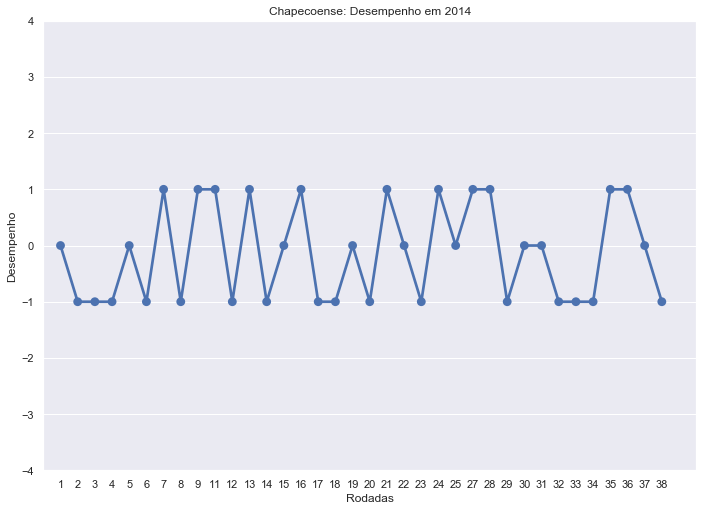

In [103]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2014_chape).set(ylim=(-4, 4), xlim=(-1,37), 
title='Chapecoense: Desempenho em 2014')

#não houve mudança de técnico neste ano

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")
plt.savefig('Chapecoense_2014')

In [104]:
mask10 = chapecoense_novo["ano2"] ==2015
ano2015_chape=chapecoense_novo[mask10]
ano2015_chape

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2015 1       Chapecoense    5.0    9.0             2.0             1.0   
     2       Chapecoense    5.0   16.0             1.0             0.0   
     3       Chapecoense    5.0   24.0             1.0             0.0   
     4       Chapecoense    5.0   30.0             3.0             1.0   
     5       Chapecoense    6.0    3.0             2.0             0.0   
     6       Chapecoense    6.0    6.0             1.0             0.0   
     7       Chapecoense    6.0   13.0             0.0             1.0   
     8       Chapecoense    6.0   21.0             0.0             1.0   
     9       Chapecoense    6.0   27.0             1.0             1.0   
     10      Chapecoense    7.0    1.0             2.0             0.0   
     11      Chapecoense    7.0    4.0             1.0             0.0   
     12      Chapecoense    7.0    8.0             1.0             0.0   
     13      Chapecoense    7.0   12.0             2.0             1.0   
     14      Chapecoense    7.0   19.0             1.0             0.0   
     15      Chapecoense    7.0   26.0             2.0             1.0   
     16      Chapecoense    8.0    2.0             0.0             0.0   
     17      Chapecoense    8.0    9.0             2.0             2.0   
     18      Chapecoense    8.0   12.0             0.0             0.0   
     19      Chapecoense    8.0   16.0             2.0             1.0   
     20      Chapecoense    8.0   23.0             1.0             0.0   
     21      Chapecoense    8.0   30.0             1.0             3.0   
     22      Chapecoense    9.0    3.0             3.0             1.0   
     23      Chapecoense    9.0    6.0             0.0             0.0   
     24      Chapecoense    9.0   10.0             0.0             0.0   
     25      Chapecoense    9.0   13.0             1.0             3.0   
     27      Chapecoense    9.0   20.0             0.0             2.0   
     28      Chapecoense    9.0   27.0             3.0             0.0   
     29      Chapecoense   10.0    4.0             5.0             1.0   
     30      Chapecoense   10.0   15.0             1.0             1.0   
     31      Chapecoense   10.0   18.0             2.0             3.0   
     32      Chapecoense   10.0   25.0             0.0             0.0   
     33      Chapecoense   11.0    1.0             0.0             0.0   
     34      Chapecoense   11.0    7.0             2.0             3.0   
     35      Chapecoense   11.0   19.0             1.0             0.0   
     36      Chapecoense   11.0   22.0             0.0             0.0   
     37      Chapecoense   11.0   29.0             1.0             3.0   

            variable_x  Rodada2_x  ano2  Resultados            Apelido  \
ano  Rodada                                                              
2015 1       home.team          1  2015           1  Vinícius Eutrópio   
     2       away.team          2  2015          -1                NaN   
     3       home.team          3  2015           1                NaN   
     4       away.team          4  2015          -1                NaN   
     5       home.team          5  2015           1                NaN   
     6       away.team          6  2015          -1                NaN   
     7       home.team          7  2015          -1                NaN   
     8       away.team          8  2015           1                NaN   
     9       home.team          9  2015           0                NaN   
     10      away.team         10  2015          -1                NaN   
     11      home.team         11  2015           1                NaN   
     12      home.team         12  2015           1                NaN   
     13      away.team         13  2015          -1                NaN   
     14      away.team         14  2015          -1                NaN   
     15      home.

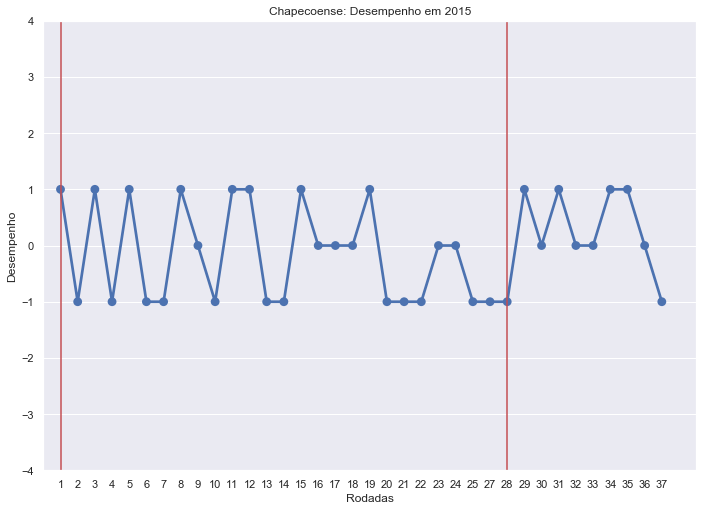

In [105]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2015_chape).set(ylim=(-4, 4), xlim=(-1,37), 
title='Chapecoense: Desempenho em 2015')

plt.axvline(0, color='r') #linha vermelha: mudança de técnico a partir daquela rodada
plt.axvline(26, color='r')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('Chapecoense_2015')

In [149]:
ano2015_chape.iloc[1:28,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2015

-1    0.481481
 1    0.296296
 0    0.222222
Name: Resultados, dtype: float64

In [106]:
ano2015_chape['Resultados'].value_counts(normalize=True)

-1    0.388889
 1    0.333333
 0    0.277778
Name: Resultados, dtype: float64

In [107]:
mask11 = chapecoense_novo["ano2"] ==2016
ano2016_chape=chapecoense_novo[mask11]
ano2016_chape

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2016 1       Chapecoense    5.0   15.0             0.0             0.0   
     2       Chapecoense    5.0   22.0             3.0             1.0   
     3       Chapecoense    5.0   25.0             2.0             2.0   
     4       Chapecoense    5.0   28.0             1.0             1.0   
     5       Chapecoense    6.0    1.0             3.0             4.0   
     6       Chapecoense    6.0    4.0             0.0             0.0   
     7       Chapecoense    6.0   11.0             2.0             1.0   
     8       Chapecoense    6.0   15.0             3.0             3.0   
     10      Chapecoense    6.0   22.0             0.0             0.0   
     11      Chapecoense    6.0   26.0             5.0             1.0   
     16      Chapecoense    7.0   24.0             2.0             1.0   
     17      Chapecoense    7.0   31.0             2.0             2.0   
     18      Chapecoense    8.0    4.0             1.0             1.0   
     19      Chapecoense    8.0    8.0             3.0             1.0   
     20      Chapecoense    8.0   15.0             1.0             0.0   
     22      Chapecoense    8.0   28.0             1.0             3.0   
     27      Chapecoense    9.0   25.0             1.0             0.0   
     29      Chapecoense   10.0    5.0             3.0             1.0   
     30      Chapecoense   10.0   12.0             3.0             0.0   
     31      Chapecoense   10.0   16.0             0.0             0.0   
     32      Chapecoense   10.0   23.0             0.0             1.0   
     33      Chapecoense   10.0   29.0             1.0             1.0   
     34      Chapecoense   11.0    6.0             1.0             0.0   
     37      Chapecoense   11.0   27.0             1.0             0.0   

            variable_x  Rodada2_x  ano2  Resultados        Apelido  Rodada2_y  \
ano  Rodada                                                                     
2016 1       away.team          1  2016           0  Guto Ferreira        1.0   
     2       home.team          2  2016           1            NaN        NaN   
     3       away.team          3  2016           0            NaN        NaN   
     4       home.team          4  2016           0            NaN        NaN   
     5       away.team          5  2016           1            NaN        NaN   
     6       home.team          6  2016           0            NaN        NaN   
     7       away.team          7  2016          -1            NaN        NaN   
     8       home.team          8  2016           0            NaN        NaN   
     10      home.team         10  2016           0            NaN        NaN   
     11      away.team         11  2016          -1            NaN        NaN   
     16      home.team         16  2016           1            NaN        NaN   
     17      away.team         17  2016           0            NaN        NaN   
     18      home.team         18  2016           0            NaN        NaN   
     19      away.team         19  2016          -1            NaN        NaN   
     20      home.team         20  2016           1            NaN        NaN   
     22      home.team         22  2016          -1            NaN        NaN   
     27      away.team         27  2016          -1            NaN        NaN   
     29      away.team         29  2016          -1            NaN        NaN   
     30      home.team         30  2016           1            NaN        NaN   
     31      away.team         31  2016           0            NaN        NaN   
     32      home.team         32  2016          -1            NaN        NaN   
     33      away.team         33  2016           0            NaN        NaN   
     34      home.team         34  2016           1            NaN        NaN   
     37      away.team         37  2016          -1            Na

In [108]:
ano2016_chape['Resultados'].value_counts(normalize=True)

 0    0.416667
-1    0.333333
 1    0.250000
Name: Resultados, dtype: float64

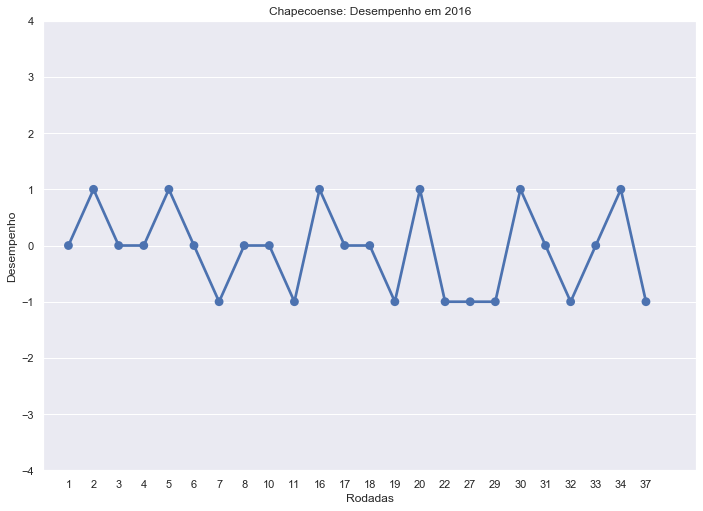

In [109]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2016_chape).set(ylim=(-4, 4), xlim=(-1,25), 
title='Chapecoense: Desempenho em 2016')

# Não houve mudança de técnico nesse ano, segundo o dataset

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('Chapecoense_2016')

In [110]:
mask12 = chapecoense_novo["ano2"] ==2017
ano2017_chape=chapecoense_novo[mask12]
ano2017_chape

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2017 1       Chapecoense    5.0   13.0             1.0             1.0   
     1       Chapecoense    5.0   13.0             1.0             1.0   
     2       Chapecoense    5.0   20.0             1.0             0.0   
     3       Chapecoense    5.0   29.0             2.0             0.0   
     4       Chapecoense    6.0    4.0             0.0             2.0   
     5       Chapecoense    6.0    8.0             3.0             6.0   
     6       Chapecoense    6.0   11.0             3.0             2.0   
     7       Chapecoense    6.0   14.0             2.0             1.0   
     8       Chapecoense    6.0   18.0             0.0             2.0   
     9       Chapecoense    6.0   22.0             5.0             1.0   
     10      Chapecoense    6.0   25.0             0.0             1.0   
     11      Chapecoense    7.0    3.0             3.0             3.0   
     12      Chapecoense    7.0    9.0             1.0             1.0   
     13      Chapecoense    7.0   13.0             3.0             0.0   
     14      Chapecoense    7.0   16.0             2.0             0.0   
     15      Chapecoense    7.0   19.0             1.0             0.0   
     16      Chapecoense    7.0   22.0             1.0             2.0   
     17      Chapecoense    7.0   30.0             1.0             2.0   
     18      Chapecoense    8.0    2.0             1.0             1.0   
     19      Chapecoense    8.0    6.0             2.0             0.0   
     21      Chapecoense    8.0   20.0             0.0             2.0   
     22      Chapecoense    8.0   27.0             1.0             0.0   
     23      Chapecoense    9.0   10.0             1.0             2.0   
     24      Chapecoense    9.0   17.0             0.0             1.0   
     25      Chapecoense    9.0   24.0             1.0             0.0   
     26      Chapecoense    9.0   30.0             1.0             1.0   
     27      Chapecoense   10.0   11.0             2.0             1.0   
     28      Chapecoense   10.0   15.0             0.0             1.0   
     29      Chapecoense   10.0   18.0             2.0             3.0   
     30      Chapecoense   10.0   22.0             2.0             0.0   
     31      Chapecoense   10.0   28.0             0.0             0.0   
     32      Chapecoense   11.0    5.0             1.0             1.0   
     33      Chapecoense   11.0    9.0             2.0             2.0   
     34      Chapecoense   11.0   13.0             2.0             0.0   
     35      Chapecoense   11.0   16.0             2.0             1.0   
     36      Chapecoense   11.0   19.0             1.0             1.0   
     37      Chapecoense   11.0   26.0             0.0             1.0   
     38      Chapecoense   12.0    3.0             2.0             1.0   

            variable_x  Rodada2_x  ano2  Resultados            Apelido  \
ano  Rodada                                                              
2017 1       away.team          1  2017           0      Guto Ferreira   
     1       away.team          1  2017           0     Vagner Mancini   
     2       home.team          2  2017           1                NaN   
     3       home.team          3  2017           1                NaN   
     4       away.team          4  2017           1                NaN   
     5       home.team          5  2017          -1                NaN   
     6       away.team          6  2017          -1                NaN   
     7       home.team          7  2017           1                NaN   
     8       home.team          8  2017          -1                NaN   
     9       away.team          9  2017          -1                NaN   
     10      home.team         10  2017          -1                NaN   
     11      away.team         11  2017           0                NaN   
     12      home.

In [111]:
ano2017_chape['Resultados'].value_counts(normalize=True)

 1    0.394737
-1    0.342105
 0    0.263158
Name: Resultados, dtype: float64

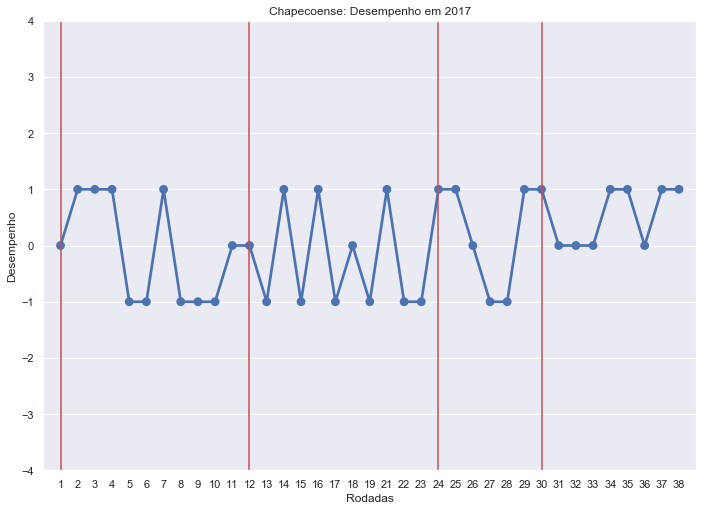

In [112]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2017_chape).set(ylim=(-4, 4), xlim=(-1,37), 
title='Chapecoense: Desempenho em 2017')

plt.axvline(0, color='r')
plt.axvline(11, color='r')
plt.axvline(22, color='r')
plt.axvline(28, color='r')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")
plt.savefig('Chapecoense_2017')

In [152]:
ano2017_chape.iloc[1:12,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2017

-1    0.454545
 1    0.363636
 0    0.181818
Name: Resultados, dtype: float64

In [153]:
ano2017_chape.iloc[12:24,8].value_counts(normalize=True) #aproveitamento do segundo técnico de 2017

-1    0.500000
 1    0.333333
 0    0.166667
Name: Resultados, dtype: float64

In [154]:
ano2017_chape.iloc[24:31,8].value_counts(normalize=True) #aproveitamento do terceiro técnico de 2017

 1    0.428571
-1    0.285714
 0    0.285714
Name: Resultados, dtype: float64

Para o Palmeiras:

In [113]:
data_troca_tec_pal['Troca']=True

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [114]:
data_troca_tec_pal

AtletaID    ClubeID Posicao  Jogos              Apelido   mes  \
ano  Rodada                                                                  
2014 1          37306  Palmeiras     tec    1.0        Gilson Kleina   4.0   
     4          84863  Palmeiras     tec    1.0     Alberto Valentim   5.0   
     19         40990  Palmeiras     tec    1.0       Dorival Júnior   9.0   
2015 1          36940  Palmeiras     tec    1.0  Oswaldo de Oliveira   5.0   
     7          84863  Palmeiras     tec    1.0     Alberto Valentim   6.0   
2017 1          42411  Palmeiras     tec    1.0                 Cuca   5.0   
     28         84863  Palmeiras     tec    1.0     Alberto Valentim  10.0   

              dia  home.score.x  away.score.x   variable  Rodada2  Troca  
ano  Rodada                                                               
2014 1       20.0           1.0           2.0  away.team        1   True  
     4       10.0           2.0           0.0  home.team        4   True  
     19       7.0           1.0           1.0  away.team       19   True  
2015 1        9.0           2.0           2.0  home.team        1   True  
     7       14.0           2.0           1.0  home.team        7   True  
2017 1       14.0           4.0           0.0  home.team        1   True  
     28      15.0           1.0           3.0  away.team       28   True

In [115]:
palmeiras_novo = pd.merge(palmeiras, data_troca_tec_pal, how='left',left_index=True, right_index=True)

In [116]:
palmeiras_novo['Troca'].fillna(False, inplace=True)

In [117]:
palmeiras_novo.drop(['AtletaID','ClubeID_y','Posicao','Jogos','mes_y','dia_y','home.score.x_y','away.score.x_y',
                      'variable_y'], axis=1,inplace=True)

In [118]:
palmeiras_novo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 149 entries, (2014, 1) to (2017, 38)
Data columns (total 12 columns):
ClubeID_x         149 non-null object
mes_x             149 non-null float64
dia_x             149 non-null float64
home.score.x_x    149 non-null float64
away.score.x_x    149 non-null float64
variable_x        149 non-null object
Rodada2_x         149 non-null int64
ano2              149 non-null int64
Resultados        149 non-null object
Apelido           7 non-null object
Rodada2_y         7 non-null float64
Troca             149 non-null bool
dtypes: bool(1), float64(5), int64(2), object(4)
memory usage: 18.7+ KB


In [119]:
palmeiras_novo.head()

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                            
2014 1       Palmeiras    4.0   20.0             1.0             2.0   
     2       Palmeiras    4.0   26.0             0.0             1.0   
     3       Palmeiras    5.0    4.0             4.0             2.0   
     4       Palmeiras    5.0   10.0             2.0             0.0   
     5       Palmeiras    5.0   18.0             0.0             1.0   

            variable_x  Rodada2_x  ano2 Resultados           Apelido  \
ano  Rodada                                                            
2014 1       away.team          1  2014          1     Gilson Kleina   
     2       home.team          2  2014         -1               NaN   
     3       away.team          3  2014         -1               NaN   
     4       home.team          4  2014          1  Alberto Valentim   
     5       away.team          5  2014          1               NaN   

             Rodada2_y  Troca  
ano  Rodada                    
2014 1             1.0   True  
     2             NaN  False  
     3             NaN  False  
     4             4.0   True  
     5             NaN  False

In [120]:
palmeiras_novo["Resultados"]=palmeiras_novo["Resultados"].apply(int) #alterando o tipo de objeto da coluna "Resultados"

Aplicou-se uma máscara para separar os dados por ano:

In [121]:
mask15 = palmeiras_novo["ano2"] ==2014
ano2014_pal=palmeiras_novo[mask15]
ano2014_pal

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                            
2014 1       Palmeiras    4.0   20.0             1.0             2.0   
     2       Palmeiras    4.0   26.0             0.0             1.0   
     3       Palmeiras    5.0    4.0             4.0             2.0   
     4       Palmeiras    5.0   10.0             2.0             0.0   
     5       Palmeiras    5.0   18.0             0.0             1.0   
     6       Palmeiras    5.0   22.0             1.0             0.0   
     7       Palmeiras    5.0   25.0             2.0             0.0   
     8       Palmeiras    5.0   28.0             0.0             2.0   
     9       Palmeiras    6.0    1.0             0.0             0.0   
     10      Palmeiras    7.0   17.0             2.0             0.0   
     11      Palmeiras    7.0   20.0             1.0             2.0   
     12      Palmeiras    7.0   27.0             2.0             0.0   
     13      Palmeiras    8.0    3.0             1.0             1.0   
     14      Palmeiras    8.0   10.0             2.0             1.0   
     15      Palmeiras    8.0   17.0             1.0             2.0   
     16      Palmeiras    8.0   20.0             2.0             1.0   
     17      Palmeiras    8.0   23.0             1.0             0.0   
     18      Palmeiras    8.0   30.0             0.0             1.0   
     19      Palmeiras    9.0    7.0             1.0             1.0   
     20      Palmeiras    9.0   10.0             1.0             0.0   
     21      Palmeiras    9.0   13.0             3.0             0.0   
     22      Palmeiras    9.0   17.0             2.0             2.0   
     23      Palmeiras    9.0   21.0             6.0             0.0   
     24      Palmeiras    9.0   25.0             2.0             0.0   
     25      Palmeiras    9.0   28.0             3.0             1.0   
     27      Palmeiras   10.0    8.0             0.0             1.0   
     28      Palmeiras   10.0   11.0             2.0             1.0   
     29      Palmeiras   10.0   19.0             1.0             3.0   
     30      Palmeiras   10.0   22.0             1.0             1.0   
     31      Palmeiras   10.0   25.0             1.0             1.0   
     32      Palmeiras   11.0    2.0             0.0             1.0   
     33      Palmeiras   11.0    8.0             0.0             2.0   
     34      Palmeiras   11.0   16.0             2.0             0.0   
     35      Palmeiras   11.0   19.0             0.0             2.0   
     36      Palmeiras   11.0   23.0             2.0             0.0   
     37      Palmeiras   11.0   29.0             3.0             1.0   
     38      Palmeiras   12.0    7.0             1.0             1.0   

            variable_x  Rodada2_x  ano2  Resultados           Apelido  \
ano  Rodada                                                             
2014 1       away.team          1  2014           1     Gilson Kleina   
     2       home.team          2  2014          -1               NaN   
     3       away.team          3  2014          -1               NaN   
     4       home.team          4  2014           1  Alberto Valentim   
     5       away.team          5  2014           1               NaN   
     6       home.team          6  2014           1               NaN   
     7       away.team          7  2014          -1               NaN   
     8       home.team          8  2014          -1               NaN   
     9       away.team          9  2014           0               NaN   
     10      away.team         10  2014          -1               NaN   
     11      home.team         11  2014          -1               NaN   
     12      away.team         12  2014          -1               NaN   
     13      home.team         13  2014           0               NaN   
     14      away.team         14  2014          -1               NaN   
     15      home.team         15  2

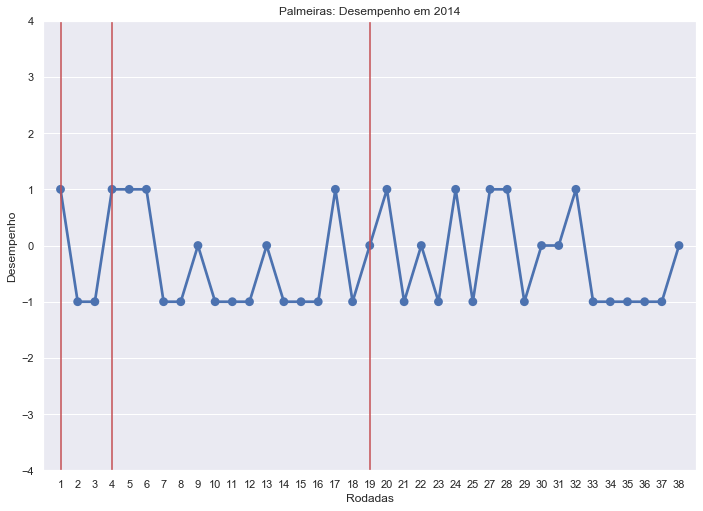

In [122]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2014_pal).set(ylim=(-4, 4), xlim=(-1,37), 
title='Palmeiras: Desempenho em 2014')

plt.axvline(0, color='r')
plt.axvline(3, color='r')
plt.axvline(18, color='r')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('Palmeiras_2014')

In [155]:
ano2014_pal.iloc[1:4,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2014

-1    0.666667
 1    0.333333
Name: Resultados, dtype: float64

In [156]:
ano2014_pal.iloc[4:19,8].value_counts(normalize=True) #aproveitamento do segundo técnico de 2014

-1    0.6
 0    0.2
 1    0.2
Name: Resultados, dtype: float64

In [157]:
ano2014_pal.iloc[19:,8].value_counts(normalize=True) #aproveitamento do terceirob técnico de 2014

-1    0.500000
 1    0.277778
 0    0.222222
Name: Resultados, dtype: float64

In [123]:
mask16 = palmeiras_novo["ano2"] ==2015
ano2015_pal=palmeiras_novo[mask16]
ano2015_pal

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                            
2015 1       Palmeiras    5.0    9.0             2.0             2.0   
     2       Palmeiras    5.0   17.0             0.0             0.0   
     3       Palmeiras    5.0   24.0             0.0             1.0   
     4       Palmeiras    5.0   31.0             0.0             2.0   
     5       Palmeiras    6.0    4.0             1.0             1.0   
     6       Palmeiras    6.0    7.0             2.0             1.0   
     7       Palmeiras    6.0   14.0             2.0             1.0   
     8       Palmeiras    6.0   20.0             1.0             0.0   
     9       Palmeiras    6.0   28.0             4.0             0.0   
     10      Palmeiras    7.0    1.0             2.0             0.0   
     11      Palmeiras    7.0    5.0             0.0             2.0   
     12      Palmeiras    7.0    8.0             3.0             0.0   
     13      Palmeiras    7.0   12.0             2.0             2.0   
     14      Palmeiras    7.0   19.0             1.0             0.0   
     15      Palmeiras    7.0   26.0             1.0             4.0   
     16      Palmeiras    8.0    2.0             0.0             1.0   
     17      Palmeiras    8.0    9.0             2.0             1.0   
     18      Palmeiras    8.0   12.0             2.0             1.0   
     19      Palmeiras    8.0   16.0             4.0             2.0   
     20      Palmeiras    8.0   23.0             2.0             1.0   
     21      Palmeiras    8.0   30.0             3.0             2.0   
     22      Palmeiras    9.0    2.0             1.0             0.0   
     23      Palmeiras    9.0    6.0             3.0             3.0   
     24      Palmeiras    9.0    9.0             1.0             0.0   
     25      Palmeiras    9.0   12.0             2.0             0.0   
     27      Palmeiras    9.0   19.0             3.0             2.0   
     28      Palmeiras    9.0   27.0             1.0             1.0   
     29      Palmeiras   10.0    4.0             5.0             1.0   
     30      Palmeiras   10.0   14.0             0.0             1.0   
     31      Palmeiras   10.0   17.0             1.0             3.0   
     32      Palmeiras   10.0   24.0             0.0             2.0   
     33      Palmeiras   11.0    1.0             2.0             1.0   
     34      Palmeiras   11.0    8.0             0.0             2.0   
     35      Palmeiras   11.0   18.0             3.0             3.0   
     36      Palmeiras   11.0   21.0             1.0             1.0   
     37      Palmeiras   11.0   29.0             0.0             2.0   

            variable_x  Rodada2_x  ano2  Resultados              Apelido  \
ano  Rodada                                                                
2015 1       home.team          1  2015           0  Oswaldo de Oliveira   
     2       away.team          2  2015           0                  NaN   
     3       home.team          3  2015          -1                  NaN   
     4       away.team          4  2015           1                  NaN   
     5       home.team          5  2015           0                  NaN   
     6       away.team          6  2015          -1                  NaN   
     7       home.team          7  2015           1     Alberto Valentim   
     8       away.team          8  2015          -1                  NaN   
     9       home.team          9  2015           1                  NaN   
     10      home.team         10  2015           1                  NaN   
     11      away.team         11  2015           1                  NaN   
     12      home.team         12  2015           1                  NaN   
     13      away.team         13  2015           0                  NaN   
     14      home.team         14  2015           1                  NaN   
     15      away.team         15  2015           1         

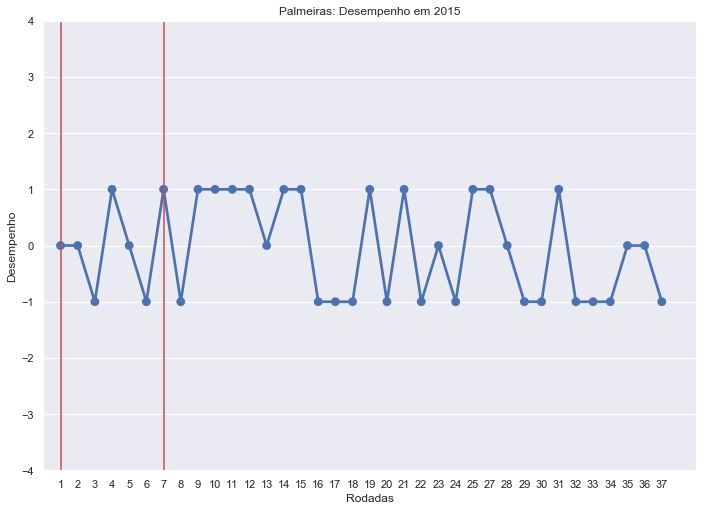

In [124]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2015_pal).set(ylim=(-4, 4), xlim=(-1,37), 
title='Palmeiras: Desempenho em 2015')

plt.axvline(0, color='r')
plt.axvline(6, color='r')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('Palmeiras_2015')

In [159]:
ano2015_pal.iloc[1:7,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2015

 1    0.333333
-1    0.333333
 0    0.333333
Name: Resultados, dtype: float64

In [160]:
ano2015_pal.iloc[7:,8].value_counts(normalize=True) #aproveitamento do segundo técnico de 2015

-1    0.448276
 1    0.379310
 0    0.172414
Name: Resultados, dtype: float64

In [125]:
mask17 = palmeiras_novo["ano2"] ==2016
ano2016_pal=palmeiras_novo[mask17]
ano2016_pal.head() #de acordo com esse dataset, não há mudanças de técnico nesse time em 2016.

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                            
2016 1       Palmeiras    5.0   14.0             4.0             0.0   
     2       Palmeiras    5.0   21.0             2.0             1.0   
     3       Palmeiras    5.0   25.0             2.0             0.0   
     4       Palmeiras    5.0   29.0             1.0             0.0   
     5       Palmeiras    6.0    2.0             4.0             3.0   

            variable_x  Rodada2_x  ano2  Resultados Apelido  Rodada2_y  Troca  
ano  Rodada                                                                    
2016 1       home.team          1  2016           1     NaN        NaN  False  
     2       away.team          2  2016          -1     NaN        NaN  False  
     3       home.team          3  2016           1     NaN        NaN  False  
     4       away.team          4  2016          -1     NaN        NaN  False  
     5       home.team          5  2016           1     NaN        NaN  False

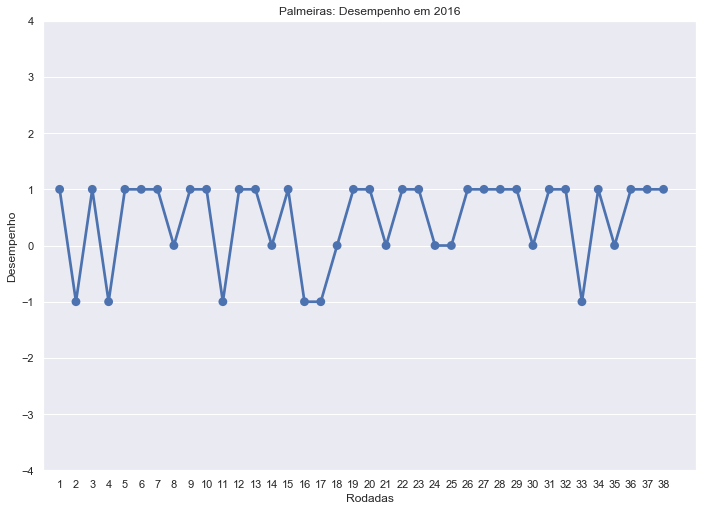

In [126]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2016_pal).set(ylim=(-4, 4), xlim=(-1,39), 
title='Palmeiras: Desempenho em 2016')


plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('Palmeiras_2016')

In [161]:
ano2016_pal['Resultados'].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2016

 1    0.631579
 0    0.210526
-1    0.157895
Name: Resultados, dtype: float64

In [127]:
mask18 = palmeiras_novo["ano2"] ==2017
ano2017_pal=palmeiras_novo[mask18]
ano2017_pal

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                            
2017 1       Palmeiras    5.0   14.0             4.0             0.0   
     2       Palmeiras    5.0   20.0             1.0             0.0   
     3       Palmeiras    5.0   27.0             2.0             0.0   
     4       Palmeiras    6.0    4.0             0.0             0.0   
     5       Palmeiras    6.0    7.0             1.0             0.0   
     6       Palmeiras    6.0   10.0             3.0             1.0   
     7       Palmeiras    6.0   14.0             1.0             0.0   
     8       Palmeiras    6.0   18.0             2.0             4.0   
     9       Palmeiras    6.0   21.0             1.0             0.0   
     10      Palmeiras    6.0   25.0             1.0             2.0   
     11      Palmeiras    7.0    1.0             1.0             0.0   
     12      Palmeiras    7.0    9.0             3.0             1.0   
     13      Palmeiras    7.0   12.0             0.0             2.0   
     14      Palmeiras    7.0   16.0             4.0             2.0   
     15      Palmeiras    7.0   19.0             2.0             2.0   
     16      Palmeiras    7.0   23.0             0.0             2.0   
     17      Palmeiras    7.0   29.0             2.0             0.0   
     18      Palmeiras    8.0    2.0             1.0             2.0   
     19      Palmeiras    8.0    6.0             0.0             1.0   
     20      Palmeiras    8.0   13.0             1.0             1.0   
     21      Palmeiras    8.0   20.0             0.0             2.0   
     22      Palmeiras    8.0   27.0             4.0             2.0   
     23      Palmeiras    9.0    9.0             1.0             1.0   
     24      Palmeiras    9.0   18.0             1.0             0.0   
     25      Palmeiras    9.0   24.0             0.0             1.0   
     26      Palmeiras    9.0   30.0             0.0             1.0   
     27      Palmeiras   10.0   12.0             2.0             2.0   
     28      Palmeiras   10.0   15.0             1.0             3.0   
     29      Palmeiras   10.0   19.0             2.0             0.0   
     30      Palmeiras   10.0   22.0             1.0             3.0   
     31      Palmeiras   10.0   30.0             2.0             2.0   
     32      Palmeiras   11.0    5.0             3.0             2.0   
     33      Palmeiras   11.0    8.0             3.0             1.0   
     34      Palmeiras   11.0   12.0             2.0             0.0   
     35      Palmeiras   11.0   16.0             5.0             1.0   
     36      Palmeiras   11.0   20.0             2.0             1.0   
     37      Palmeiras   11.0   27.0             2.0             0.0   
     38      Palmeiras   12.0    3.0             3.0             0.0   

            variable_x  Rodada2_x  ano2  Resultados           Apelido  \
ano  Rodada                                                             
2017 1       home.team          1  2017           1              Cuca   
     2       away.team          2  2017          -1               NaN   
     3       away.team          3  2017          -1               NaN   
     4       home.team          4  2017           0               NaN   
     5       away.team          5  2017          -1               NaN   
     6       home.team          6  2017           1               NaN   
     7       away.team          7  2017          -1               NaN   
     8       away.team          8  2017           1               NaN   
     9       home.team          9  2017           1               NaN   
     10      away.team         10  2017           1               NaN   
     11      home.team         11  2017           1               NaN   
     12      away.team         12  2017          -1               NaN   
     13      home.team         13  2017          -1               NaN   
     14      home.team         14  20

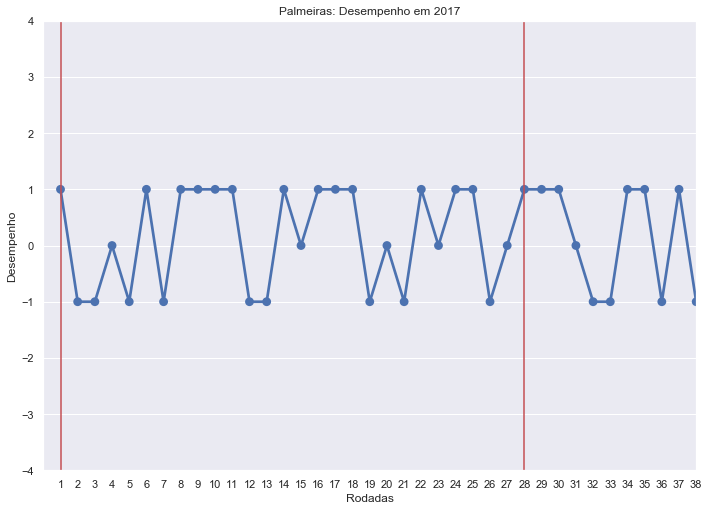

In [128]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2017_pal).set(ylim=(-4, 4), xlim=(-1,37), 
title='Palmeiras: Desempenho em 2017')

plt.axvline(0, color='r')
plt.axvline(27, color='r')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('Palmeiras_2017')

In [162]:
ano2017_pal.iloc[1:28,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2017

 1    0.481481
-1    0.333333
 0    0.185185
Name: Resultados, dtype: float64

In [163]:
ano2017_pal.iloc[28:,8].value_counts(normalize=True) #aproveitamento do segundo técnico de 2017

 1    0.5
-1    0.4
 0    0.1
Name: Resultados, dtype: float64

Para o Atlético-MG:

In [129]:
data_troca_tec_cam['Troca']=True

C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [130]:
data_troca_tec_cam

AtletaID      ClubeID Posicao  Jogos              Apelido   mes  \
ano  Rodada                                                                    
2014 1          36943  Atlético-MG     tec    1.0        Paulo Autuori   4.0   
     2          40025  Atlético-MG     tec    1.0          Levir Culpi   4.0   
2015 1          40025  Atlético-MG     tec    1.0          Levir Culpi   5.0   
2016 2          62136  Atlético-MG     tec   35.0     Marcelo Oliveira   5.0   
2017 1          79437  Atlético-MG     tec    1.0       Roger Machado    5.0   
     17         70526  Atlético-MG     tec    1.0       Rogério Micale   7.0   
     26         36940  Atlético-MG     tec    1.0  Oswaldo de Oliveira  10.0   

              dia  home.score.x  away.score.x   variable  Rodada2  Troca  
ano  Rodada                                                               
2014 1       20.0           0.0           0.0  home.team        1   True  
     2       27.0           2.0           1.0  away.team        2   True  
2015 1        9.0           2.0           2.0  away.team        1   True  
2016 2       22.0           1.0           1.0  away.team        2   True  
2017 1       13.0           1.0           1.0  away.team        1   True  
     17      30.0           0.0           2.0  away.team       17   True  
     26       1.0           0.0           2.0  away.team       26   True

In [131]:
cam_novo = pd.merge(atletmg, data_troca_tec_cam, how='left',left_index=True, right_index=True)

In [132]:
cam_novo['Troca'].fillna(False, inplace=True)

In [133]:
cam_novo.drop(['AtletaID','ClubeID_y','Posicao','Jogos','mes_y','dia_y','home.score.x_y','away.score.x_y',
                      'variable_y'], axis=1,inplace=True)

In [134]:
cam_novo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 146 entries, (2014, 1) to (2017, 38)
Data columns (total 12 columns):
ClubeID_x         146 non-null object
mes_x             146 non-null float64
dia_x             146 non-null float64
home.score.x_x    146 non-null float64
away.score.x_x    146 non-null float64
variable_x        146 non-null object
Rodada2_x         146 non-null int64
ano2              146 non-null int64
Resultados        146 non-null object
Apelido           7 non-null object
Rodada2_y         7 non-null float64
Troca             146 non-null bool
dtypes: bool(1), float64(5), int64(2), object(4)
memory usage: 18.4+ KB


In [135]:
cam_novo.head()

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2014 1       Atlético-MG    4.0   20.0             0.0             0.0   
     2       Atlético-MG    4.0   27.0             2.0             1.0   
     3       Atlético-MG    5.0    4.0             0.0             1.0   
     4       Atlético-MG    5.0   11.0             2.0             1.0   
     5       Atlético-MG    5.0   18.0             1.0             2.0   

            variable_x  Rodada2_x  ano2 Resultados        Apelido  Rodada2_y  \
ano  Rodada                                                                    
2014 1       home.team          1  2014          0  Paulo Autuori        1.0   
     2       away.team          2  2014         -1    Levir Culpi        2.0   
     3       home.team          3  2014         -1            NaN        NaN   
     4       home.team          4  2014          1            NaN        NaN   
     5       away.team          5  2014          1            NaN        NaN   

             Troca  
ano  Rodada         
2014 1        True  
     2        True  
     3       False  
     4       False  
     5       False

In [136]:
cam_novo["Resultados"]=cam_novo["Resultados"].apply(int) #alterando o tipo de objeto da coluna "Resultados"

Aplicou-se uma máscara para separar os dados por ano:

In [137]:
mask20 = cam_novo["ano2"] ==2014
ano2014_cam=cam_novo[mask20]
ano2014_cam

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2014 1       Atlético-MG    4.0   20.0             0.0             0.0   
     2       Atlético-MG    4.0   27.0             2.0             1.0   
     3       Atlético-MG    5.0    4.0             0.0             1.0   
     4       Atlético-MG    5.0   11.0             2.0             1.0   
     5       Atlético-MG    5.0   18.0             1.0             2.0   
     6       Atlético-MG    5.0   22.0             2.0             3.0   
     7       Atlético-MG    5.0   25.0             0.0             0.0   
     8       Atlético-MG    5.0   28.0             2.0             0.0   
     9       Atlético-MG    5.0   31.0             2.0             1.0   
     11      Atlético-MG    7.0   19.0             1.0             1.0   
     12      Atlético-MG    7.0   27.0             2.0             1.0   
     13      Atlético-MG    8.0    3.0             3.0             1.0   
     14      Atlético-MG    8.0   10.0             2.0             1.0   
     15      Atlético-MG    8.0   17.0             2.0             2.0   
     16      Atlético-MG    8.0   20.0             2.0             1.0   
     17      Atlético-MG    8.0   23.0             1.0             0.0   
     18      Atlético-MG    8.0   31.0             0.0             0.0   
     19      Atlético-MG    9.0    7.0             1.0             0.0   
     20      Atlético-MG    9.0   11.0             1.0             0.0   
     21      Atlético-MG    9.0   14.0             0.0             0.0   
     22      Atlético-MG    9.0   18.0             2.0             3.0   
     23      Atlético-MG    9.0   21.0             2.0             3.0   
     24      Atlético-MG    9.0   25.0             3.0             2.0   
     25      Atlético-MG    9.0   28.0             2.0             0.0   
     26      Atlético-MG   10.0    4.0             3.0             1.0   
     27      Atlético-MG   10.0    9.0             0.0             0.0   
     28      Atlético-MG   10.0   12.0             1.0             0.0   
     29      Atlético-MG   10.0   18.0             1.0             0.0   
     30      Atlético-MG   10.0   21.0             1.0             1.0   
     31      Atlético-MG   10.0   25.0             3.0             2.0   
     32      Atlético-MG   11.0    2.0             1.0             0.0   
     33      Atlético-MG   11.0    8.0             0.0             2.0   
     34      Atlético-MG   11.0   16.0             1.0             1.0   
     35      Atlético-MG   11.0   19.0             4.0             0.0   
     36      Atlético-MG   11.0   22.0             2.0             1.0   
     37      Atlético-MG   11.0   30.0             1.0             2.0   
     38      Atlético-MG   12.0    7.0             0.0             0.0   

            variable_x  Rodada2_x  ano2  Resultados        Apelido  Rodada2_y  \
ano  Rodada                                                                     
2014 1       home.team          1  2014           0  Paulo Autuori        1.0   
     2       away.team          2  2014          -1    Levir Culpi        2.0   
     3       home.team          3  2014          -1            NaN        NaN   
     4       home.team          4  2014           1            NaN        NaN   
     5       away.team          5  2014           1            NaN        NaN   
     6       away.team          6  2014           1            NaN        NaN   
     7       home.team          7  2014           0            NaN        NaN   
     8       home.team          8  2014           1            NaN        NaN   
     9       away.team          9  2014          -1            NaN        NaN   
     11      home.team         11  2014           0            NaN        NaN   
     12      away.team         12  2014          -1            NaN        NaN   
     13      home.team         13  2014           1            NaN        N

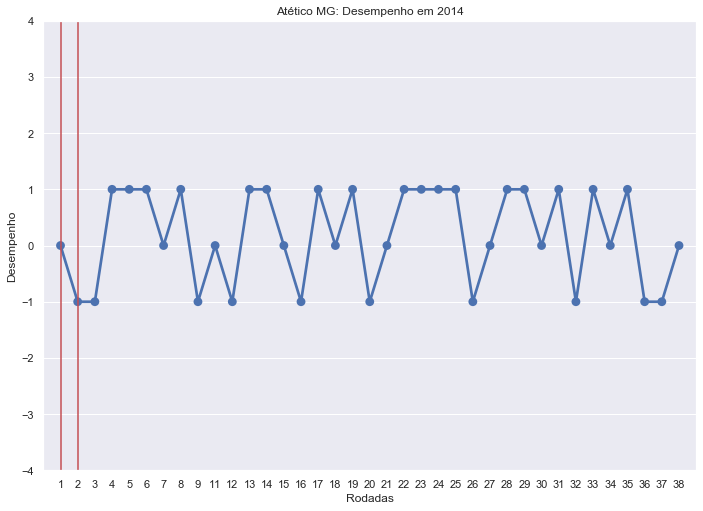

In [138]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2014_cam).set(ylim=(-4, 4), xlim=(-1,37), 
title='Atético MG: Desempenho em 2014')

plt.axvline(0, color='r')
plt.axvline(1, color='r')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('AtleticoMG_2014')

In [164]:
ano2014_cam.iloc[2:,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2014

 1    0.485714
 0    0.257143
-1    0.257143
Name: Resultados, dtype: float64

In [139]:
mask21 = cam_novo["ano2"] ==2015
ano2015_cam=cam_novo[mask21]
ano2015_cam

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2015 1       Atlético-MG    5.0    9.0             2.0             2.0   
     2       Atlético-MG    5.0   17.0             4.0             1.0   
     3       Atlético-MG    5.0   24.0             1.0             0.0   
     4       Atlético-MG    5.0   31.0             3.0             0.0   
     5       Atlético-MG    6.0    3.0             1.0             4.0   
     6       Atlético-MG    6.0    6.0             1.0             3.0   
     8       Atlético-MG    6.0   20.0             0.0             2.0   
     9       Atlético-MG    6.0   28.0             1.0             0.0   
     10      Atlético-MG    7.0    1.0             2.0             0.0   
     11      Atlético-MG    7.0    5.0             1.0             3.0   
     12      Atlético-MG    7.0    8.0             2.0             1.0   
     13      Atlético-MG    7.0   11.0             0.0             2.0   
     14      Atlético-MG    7.0   18.0             1.0             0.0   
     15      Atlético-MG    7.0   25.0             1.0             0.0   
     17      Atlético-MG    8.0    9.0             0.0             0.0   
     18      Atlético-MG    8.0   13.0             0.0             2.0   
     19      Atlético-MG    8.0   16.0             2.0             1.0   
     20      Atlético-MG    8.0   23.0             2.0             1.0   
     21      Atlético-MG    8.0   30.0             1.0             2.0   
     22      Atlético-MG    9.0    2.0             0.0             1.0   
     23      Atlético-MG    9.0    5.0             1.0             2.0   
     24      Atlético-MG    9.0    9.0             2.0             0.0   
     25      Atlético-MG    9.0   13.0             1.0             1.0   
     27      Atlético-MG    9.0   20.0             4.0             1.0   
     28      Atlético-MG    9.0   27.0             2.0             2.0   
     29      Atlético-MG   10.0    3.0             0.0             3.0   
     30      Atlético-MG   10.0   14.0             2.0             1.0   
     31      Atlético-MG   10.0   18.0             4.0             1.0   
     32      Atlético-MG   10.0   25.0             2.0             1.0   
     33      Atlético-MG   11.0    1.0             0.0             3.0   
     34      Atlético-MG   11.0    8.0             0.0             1.0   
     35      Atlético-MG   11.0   19.0             4.0             2.0   
     36      Atlético-MG   11.0   22.0             2.0             2.0   
     37      Atlético-MG   11.0   29.0             2.0             1.0   

            variable_x  Rodada2_x  ano2  Resultados      Apelido  Rodada2_y  \
ano  Rodada                                                                   
2015 1       away.team          1  2015           0  Levir Culpi        1.0   
     2       home.team          2  2015           1          NaN        NaN   
     3       away.team          3  2015          -1          NaN        NaN   
     4       home.team          4  2015           1          NaN        NaN   
     5       away.team          5  2015           1          NaN        NaN   
     6       home.team          6  2015          -1          NaN        NaN   
     8       away.team          8  2015           1          NaN        NaN   
     9       home.team          9  2015           1          NaN        NaN   
     10      home.team         10  2015           1          NaN        NaN   
     11      away.team         11  2015           1          NaN        NaN   
     12      home.team         12  2015           1          NaN        NaN   
     13      away.team         13  2015           1          NaN        NaN   
     14      away.team         14  2015          -1          NaN        NaN   
     15      home.team         15  2015           1          NaN        NaN   
     17      away.team         17  2015           0          NaN        NaN   
     18

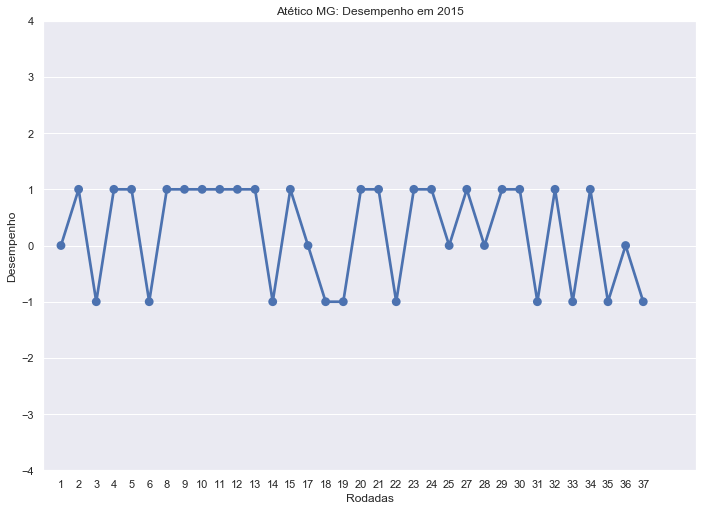

In [140]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2015_cam).set(ylim=(-4, 4), xlim=(-1,36), 
title='Atético MG: Desempenho em 2015')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('AtleticoMG_2015')

In [165]:
ano2015_cam["Resultados"].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2015

 1    0.558824
-1    0.294118
 0    0.147059
Name: Resultados, dtype: float64

In [141]:
mask22 = cam_novo["ano2"] ==2016
ano2016_cam=cam_novo[mask22]
ano2016_cam

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2016 1       Atlético-MG    5.0   14.0             1.0             0.0   
     2       Atlético-MG    5.0   22.0             1.0             1.0   
     3       Atlético-MG    5.0   26.0             0.0             3.0   
     4       Atlético-MG    5.0   29.0             1.0             1.0   
     5       Atlético-MG    6.0    1.0             1.0             1.0   
     6       Atlético-MG    6.0    5.0             4.0             4.0   
     7       Atlético-MG    6.0   12.0             2.0             3.0   
     8       Atlético-MG    6.0   16.0             2.0             0.0   
     9       Atlético-MG    6.0   19.0             3.0             0.0   
     10      Atlético-MG    6.0   22.0             2.0             1.0   
     11      Atlético-MG    6.0   26.0             0.0             1.0   
     12      Atlético-MG    6.0   30.0             5.0             3.0   
     13      Atlético-MG    7.0    3.0             1.0             1.0   
     14      Atlético-MG    7.0   10.0             2.0             0.0   
     15      Atlético-MG    7.0   18.0             2.0             1.0   
     16      Atlético-MG    7.0   24.0             0.0             1.0   
     17      Atlético-MG    7.0   30.0             3.0             0.0   
     18      Atlético-MG    8.0    4.0             1.0             2.0   
     19      Atlético-MG    8.0    8.0             3.0             1.0   
     20      Atlético-MG    8.0   14.0             3.0             0.0   
     21      Atlético-MG    8.0   21.0             1.0             0.0   
     22      Atlético-MG    8.0   28.0             1.0             1.0   
     23      Atlético-MG    9.0    7.0             2.0             1.0   
     24      Atlético-MG    9.0   12.0             4.0             2.0   
     25      Atlético-MG    9.0   15.0             1.0             0.0   
     26      Atlético-MG    9.0   18.0             1.0             1.0   
     27      Atlético-MG    9.0   25.0             3.0             1.0   
     28      Atlético-MG   10.0    1.0             1.0             2.0   
     29      Atlético-MG   10.0    5.0             0.0             0.0   
     30      Atlético-MG   10.0   13.0             3.0             0.0   
     31      Atlético-MG   10.0   16.0             3.0             2.0   
     32      Atlético-MG   10.0   23.0             3.0             0.0   
     33      Atlético-MG   10.0   29.0             2.0             2.0   
     34      Atlético-MG   11.0    6.0             2.0             0.0   
     35      Atlético-MG   11.0   17.0             1.0             1.0   
     36      Atlético-MG   11.0   20.0             3.0             3.0   
     37      Atlético-MG   11.0   27.0             1.0             2.0   

            variable_x  Rodada2_x  ano2  Resultados           Apelido  \
ano  Rodada                                                             
2016 1       home.team          1  2016           1               NaN   
     2       away.team          2  2016           0  Marcelo Oliveira   
     3       home.team          3  2016          -1               NaN   
     4       away.team          4  2016           0               NaN   
     5       home.team          5  2016           0               NaN   
     6       away.team          6  2016           0               NaN   
     7       home.team          7  2016          -1               NaN   
     8       away.team          8  2016          -1               NaN   
     9       home.team          9  2016           1               NaN   
     10      home.team         10  2016           1               NaN   
     11      away.team         11  2016           1               NaN   
     12      home.team         12  2016           1               NaN   
     13      away.team         13  2016           0               NaN   
     14      away.team         14

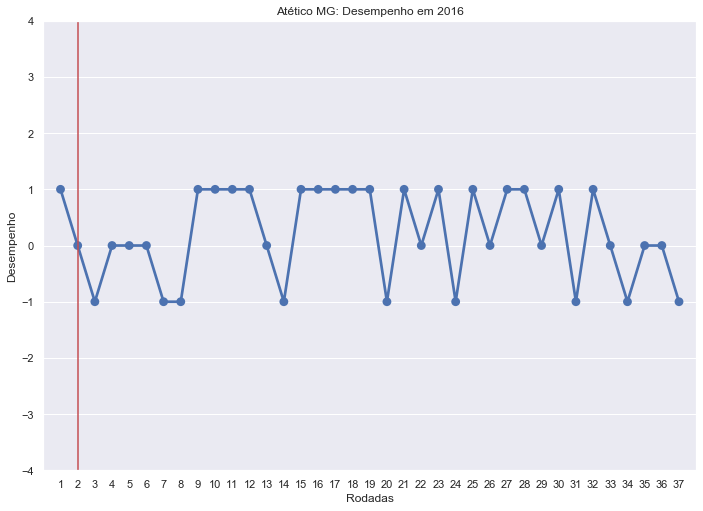

In [142]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2016_cam).set(ylim=(-4, 4), xlim=(-1,37), 
title='Atético MG: Desempenho em 2016')

plt.axvline(1, color='r')


plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('AtleticoMG_2016')

In [166]:
ano2016_cam.iloc[2:,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2016

 1    0.457143
 0    0.285714
-1    0.257143
Name: Resultados, dtype: float64

In [143]:
mask23 = cam_novo["ano2"] ==2017
ano2017_cam=cam_novo[mask23]
ano2017_cam

ClubeID_x  mes_x  dia_x  home.score.x_x  away.score.x_x  \
ano  Rodada                                                              
2017 1       Atlético-MG    5.0   13.0             1.0             1.0   
     2       Atlético-MG    5.0   21.0             1.0             2.0   
     3       Atlético-MG    5.0   28.0             2.0             2.0   
     4       Atlético-MG    6.0    4.0             0.0             0.0   
     5       Atlético-MG    6.0    7.0             1.0             0.0   
     6       Atlético-MG    6.0   11.0             2.0             0.0   
     7       Atlético-MG    6.0   14.0             0.0             1.0   
     8       Atlético-MG    6.0   18.0             1.0             2.0   
     9       Atlético-MG    6.0   21.0             2.0             2.0   
     10      Atlético-MG    6.0   25.0             0.0             1.0   
     11      Atlético-MG    7.0    2.0             3.0             1.0   
     12      Atlético-MG    7.0    9.0             1.0             1.0   
     13      Atlético-MG    7.0   12.0             0.0             1.0   
     14      Atlético-MG    7.0   16.0             1.0             2.0   
     15      Atlético-MG    7.0   19.0             0.0             2.0   
     16      Atlético-MG    7.0   23.0             1.0             2.0   
     17      Atlético-MG    7.0   30.0             0.0             2.0   
     18      Atlético-MG    8.0    2.0             0.0             2.0   
     19      Atlético-MG    8.0    6.0             2.0             0.0   
     20      Atlético-MG    8.0   13.0             2.0             0.0   
     21      Atlético-MG    8.0   21.0             2.0             1.0   
     22      Atlético-MG    8.0   27.0             1.0             2.0   
     23      Atlético-MG    9.0    9.0             1.0             1.0   
     24      Atlético-MG    9.0   17.0             1.0             1.0   
     25      Atlético-MG    9.0   24.0             1.0             3.0   
     26      Atlético-MG   10.0    1.0             0.0             2.0   
     27      Atlético-MG   10.0   11.0             1.0             0.0   
     28      Atlético-MG   10.0   15.0             1.0             1.0   
     29      Atlético-MG   10.0   18.0             2.0             3.0   
     30      Atlético-MG   10.0   22.0             1.0             3.0   
     31      Atlético-MG   10.0   29.0             0.0             0.0   
     32      Atlético-MG   11.0    4.0             3.0             1.0   
     33      Atlético-MG   11.0    9.0             3.0             2.0   
     34      Atlético-MG   11.0   12.0             2.0             2.0   
     35      Atlético-MG   11.0   15.0             1.0             1.0   
     36      Atlético-MG   11.0   19.0             3.0             0.0   
     37      Atlético-MG   11.0   26.0             2.0             2.0   
     38      Atlético-MG   12.0    3.0             4.0             3.0   

            variable_x  Rodada2_x  ano2  Resultados              Apelido  \
ano  Rodada                                                                
2017 1       away.team          1  2017           0       Roger Machado    
     2       home.team          2  2017          -1                  NaN   
     3       home.team          3  2017           0                  NaN   
     4       away.team          4  2017           0                  NaN   
     5       home.team          5  2017           1                  NaN   
     6       away.team          6  2017          -1                  NaN   
     7       home.team          7  2017          -1                  NaN   
     8       away.team          8  2017           1                  NaN   
     9       home.team          9  2017           0                  NaN   
     10      away.team         10  2017           1                  NaN   
     11      home.team         11  2017           1                  NaN   
     12      away.team         12  2017           0               

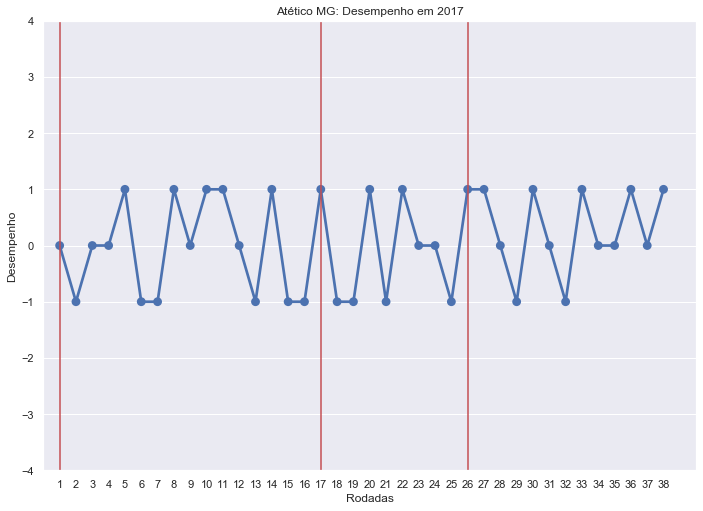

In [145]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pointplot(x='Rodada2_x', y="Resultados",ci=None, data=ano2017_cam).set(ylim=(-4, 4), xlim=(-1,39), 
title='Atético MG: Desempenho em 2017')

plt.axvline(0, color='r')
plt.axvline(16, color='r')
plt.axvline(25, color='r')

plt.xlabel("Rodadas")
plt.ylabel("Desempenho")

plt.savefig('AtleticoMG_2017')

In [167]:
ano2017_cam.iloc[1:17,8].value_counts(normalize=True) #aproveitamento do primeiro técnico de 2017

 1    0.375
-1    0.375
 0    0.250
Name: Resultados, dtype: float64

In [168]:
ano2017_cam.iloc[17:26,8].value_counts(normalize=True) #aproveitamento do segundo técnico de 2017

-1    0.444444
 1    0.333333
 0    0.222222
Name: Resultados, dtype: float64

### Possíveis conclusões:

Feito essas análises, algumas conclusões podem ser feitas:

- Esse dataset está incompleto quanto à linha temporal da troca de técnicos de um time. Isso porque ele só registra a troca quando é feita durante o período do campeonato brasileiro. Ou seja, em um ano em que o time não apresenta troca de técnico, não necessariamente significa que ele permaneceu com o mesmo profissional por todo esse tempo, e sim, que a troca pode ter sido realizada durante os campeonatos estaduais, que antecedem o brasileiro.

- De uma forma geral, aproveitamentos com menos de 37% de vitórias tendem a levar à troca de técnicos, em no máximo 4 meses, a não ser que o campeonato esteja acabando. Nesse caso, nota-se a tendência de permanecer com o mesmo técnico até o fim daquele ano, e trocar no início da temporada seguinte.

- Aproveitamentos superiores a 55% de vitórias tendem a não levar à troca de técnicos.
